In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


df = pd.read_csv('Bangladesh_1942-2025_Filtered_For_Git-1.csv')
df['ISO_TIME'] = pd.to_datetime(df['ISO_TIME'])


df = df[df['Season_Year'] >= 1900].copy()


def angleFromCoordinate(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dLon = (lon2 - lon1)
    y = math.sin(dLon) * math.cos(lat2)
    x = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(dLon)
    brng = math.atan2(y, x)
    brng = math.degrees(brng)
    brng = (brng + 360) % 360
    return 360 - brng

angles = []
prev_lat, prev_lon, prev_sid = None, None, None

for index, row in df.iterrows():
    if prev_lat is None or prev_sid != row['SID']:
        angles.append(0.0)
    else:
        angles.append(angleFromCoordinate(prev_lat, prev_lon, row['LAT'], row['LON']))
    prev_lat, prev_lon, prev_sid = row['LAT'], row['LON'], row['SID']

df['ANGLE'] = angles


df_sorted = df.sort_values(by=['SID', 'ISO_TIME']).copy()

df_sorted['TIME_DIFFERENCE_hours'] = df_sorted.groupby('SID')['ISO_TIME'].transform(
    lambda x: (x - x.min()).dt.total_seconds() / 3600
)


df_sorted['Season_Feature'] = df_sorted['ISO_TIME'].dt.month // 4


selected_features = [
    'NUMBER', 'SUBBASIN', 'DIST2LAND', 'LANDFALL',
    'ANGLE', 'Haversine Distance', 'TIME_DIFFERENCE_hours',
    'Day_of_the_Week', 'Month', 'Hour_of_the_Week', 'Season_Feature'
]

X = df_sorted[selected_features].fillna(0)
y_lat = df_sorted['LAT']
y_lon = df_sorted['LON']

# Train and Test:
X_train, X_test, y_train_lat, y_test_lat = train_test_split(X, y_lat, test_size=0.2, random_state=42)
_, _, y_train_lon, y_test_lon = train_test_split(X, y_lon, test_size=0.2, random_state=42)

# Latitude Model
model_lat = LinearRegression().fit(X_train, y_train_lat)
y_pred_lat = model_lat.predict(X_test)

# Longitude Model:
model_lon = LinearRegression().fit(X_train, y_train_lon)
y_pred_lon = model_lon.predict(X_test)

# Final Metrics:
print("--- Results for Bangladesh Dataset ---")
print(f"RMSE (Latitude): {np.sqrt(mean_squared_error(y_test_lat, y_pred_lat)):.4f}")
print(f"RMSE (Longitude): {np.sqrt(mean_squared_error(y_test_lon, y_pred_lon)):.4f}")
print(f"R2 Score (Latitude): {r2_score(y_test_lat, y_pred_lat):.4f}")
print(f"R2 Score (Longitude): {r2_score(y_test_lon, y_pred_lon):.4f}")

--- Results for Bangladesh Dataset ---
RMSE (Latitude): 0.7101
RMSE (Longitude): 1.2688
R2 Score (Latitude): 0.6712
R2 Score (Longitude): 0.1527


In [2]:
from sklearn.ensemble import RandomForestRegressor

model_lat = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
model_lon = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

model_lat.fit(X_train, y_train_lat)
model_lon.fit(X_train, y_train_lon)

RandomForestRegressor(max_depth=10, random_state=42)

In [3]:
y_pred_lat = model_lat.predict(X_test)
y_pred_lon = model_lon.predict(X_test)

# Metrics
print("--- Random Forest Results for Bangladesh Dataset ---")
print(f"RMSE (Latitude): {np.sqrt(mean_squared_error(y_test_lat, y_pred_lat)):.4f}")
print(f"RMSE (Longitude): {np.sqrt(mean_squared_error(y_test_lon, y_pred_lon)):.4f}")
print(f"R2 Score (Latitude): {r2_score(y_test_lat, y_pred_lat):.4f}")
print(f"R2 Score (Longitude): {r2_score(y_test_lon, y_pred_lon):.4f}")

--- Random Forest Results for Bangladesh Dataset ---
RMSE (Latitude): 0.4315
RMSE (Longitude): 0.9841
R2 Score (Latitude): 0.8786
R2 Score (Longitude): 0.4902


# **CNN:**

In [4]:
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense


df = pd.read_csv('Bangladesh_1942-2025_Filtered_For_Git-1.csv')
df['ISO_TIME'] = pd.to_datetime(df['ISO_TIME'])
df = df[df['Season_Year'] >= 1900].copy()

def angleFromCoordinate(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dLon = (lon2 - lon1)
    y = math.sin(dLon) * math.cos(lat2)
    x = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(dLon)
    brng = math.atan2(y, x)
    brng = math.degrees(brng)
    brng = (brng + 360) % 360
    return 360 - brng

angles = []
prev_lat, prev_lon, prev_sid = None, None, None
for index, row in df.iterrows():
    if prev_lat is None or prev_sid != row['SID']:
        angles.append(0.0)
    else:
        angles.append(angleFromCoordinate(prev_lat, prev_lon, row['LAT'], row['LON']))
    prev_lat, prev_lon, prev_sid = row['LAT'], row['LON'], row['SID']
df['ANGLE'] = angles

df_sorted = df.sort_values(by=['SID', 'ISO_TIME']).copy()
df_sorted['TIME_DIFFERENCE_hours'] = df_sorted.groupby('SID')['ISO_TIME'].transform(
    lambda x: (x - x.min()).dt.total_seconds() / 3600
)
df_sorted['Season_Feature'] = df_sorted['ISO_TIME'].dt.month // 4


selected_features = [
    'NUMBER', 'SUBBASIN', 'DIST2LAND', 'LANDFALL',
    'ANGLE', 'Haversine Distance', 'TIME_DIFFERENCE_hours',
    'Day_of_the_Week', 'Month', 'Hour_of_the_Week', 'Season_Feature'
]

X = df_sorted[selected_features].fillna(0).values
y_lat = df_sorted['LAT'].values
y_lon = df_sorted['LON'].values

# Standardizing features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_lat_train, y_lat_test, y_lon_train, y_lon_test = train_test_split(
    X_scaled, y_lat, y_lon, test_size=0.2, random_state=42
)


X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Latitude CNN Model:
model_lat_cnn = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1)
])

model_lat_cnn.compile(optimizer='adam', loss='mse')
model_lat_cnn.fit(X_train_cnn, y_lat_train, epochs=50, batch_size=32, verbose=0)

# Longitude CNN Model:
model_lon_cnn = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1)
])

model_lon_cnn.compile(optimizer='adam', loss='mse')
model_lon_cnn.fit(X_train_cnn, y_lon_train, epochs=50, batch_size=32, verbose=0)

# Evaluation:
y_pred_lat = model_lat_cnn.predict(X_test_cnn).flatten()
y_pred_lon = model_lon_cnn.predict(X_test_cnn).flatten()

print("--- CNN Results for Bangladesh ---")
print(f"RMSE (Latitude): {np.sqrt(mean_squared_error(y_lat_test, y_pred_lat)):.4f}")
print(f"RMSE (Longitude): {np.sqrt(mean_squared_error(y_lon_test, y_pred_lon)):.4f}")
print(f"R2 Score (Latitude): {r2_score(y_lat_test, y_pred_lat):.4f}")
print(f"R2 Score (Longitude): {r2_score(y_lon_test, y_pred_lon):.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
--- CNN Results for Bangladesh ---
RMSE (Latitude): 0.6135
RMSE (Longitude): 1.6522
R2 Score (Latitude): 0.7545
R2 Score (Longitude): -0.4367


In [5]:
model_lon_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 9, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 2, 32)          │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │         3,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,501 (173.84 KB)

 Trainable params: 14,833 (57.94 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 29,668 (115.89 KB)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Final Latitude Test Loss (MSE): 0.39752092957496643
Final Longitude Test Loss (MSE): 1.747361183166504


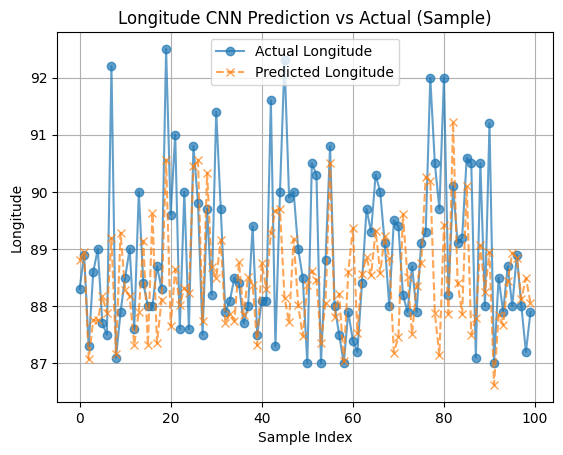

In [7]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense


def build_cnn():
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(100, activation='relu'),
        Dense(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

model_lat_cnn = build_cnn()
model_lat_cnn.fit(X_train_cnn, y_lat_train, epochs=30, batch_size=32, verbose=0)

model_lon_cnn = build_cnn()
model_lon_cnn.fit(X_train_cnn, y_lon_train, epochs=30, batch_size=32, verbose=0)


sample_size = min(100, len(X_test_cnn))
sample_indices = np.random.choice(len(X_test_cnn), size=sample_size, replace=False)
X_sample = X_test_cnn[sample_indices]
y_lat_sample = y_lat_test[sample_indices]
y_lon_sample = y_lon_test[sample_indices]


y_lat_pred_sample = model_lat_cnn.predict(X_sample).flatten()
y_lon_pred_sample = model_lon_cnn.predict(X_sample).flatten()


plt.clf()
plt.plot(y_lat_sample, label='Actual Latitude', marker='o', linestyle='-', alpha=0.7)
plt.plot(y_lat_pred_sample, label='Predicted Latitude', marker='x', linestyle='--', alpha=0.7)
plt.title('Latitude CNN Prediction vs Actual (Sample)')
plt.xlabel('Sample Index')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.savefig('lat_cnn_comparison.png')


plt.clf()
plt.plot(y_lon_sample, label='Actual Longitude', marker='o', linestyle='-', alpha=0.7)
plt.plot(y_lon_pred_sample, label='Predicted Longitude', marker='x', linestyle='--', alpha=0.7)
plt.title('Longitude CNN Prediction vs Actual (Sample)')
plt.xlabel('Sample Index')
plt.ylabel('Longitude')
plt.legend()
plt.grid(True)
plt.savefig('lon_comparison.png')


test_loss_lat = model_lat_cnn.evaluate(X_test_cnn, y_lat_test, verbose=0)
test_loss_lon = model_lon_cnn.evaluate(X_test_cnn, y_lon_test, verbose=0)
print(f"Final Latitude Test Loss (MSE): {test_loss_lat}")
print(f"Final Longitude Test Loss (MSE): {test_loss_lon}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


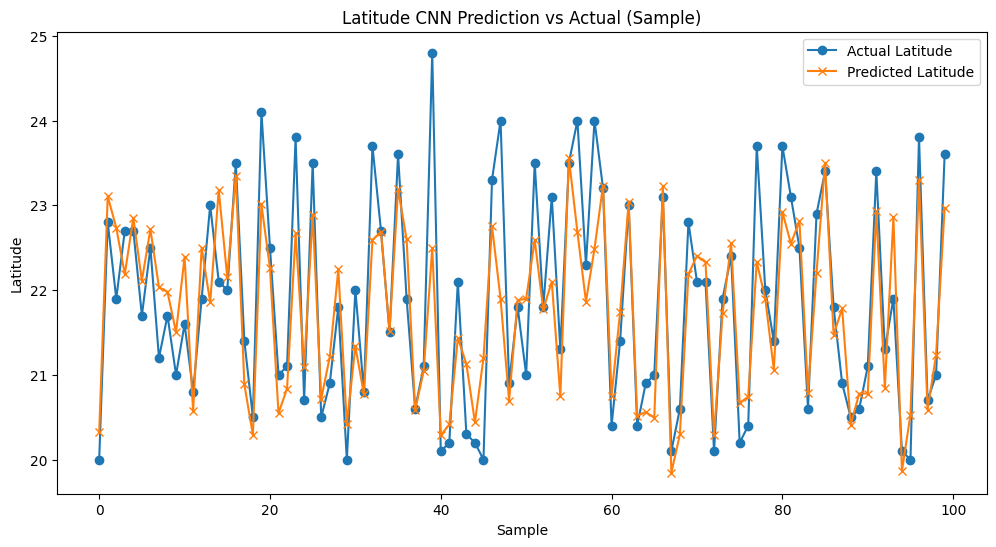

In [8]:
y_lat_pred_sample = model_lat_cnn.predict(X_sample).flatten()
plt.figure(figsize=(12, 6))
plt.plot(y_lat_sample, label='Actual Latitude', marker='o')
plt.plot(y_lat_pred_sample, label='Predicted Latitude', marker='x')
plt.title('Latitude CNN Prediction vs Actual (Sample)')
plt.xlabel('Sample')
plt.ylabel('Latitude')
plt.legend()
plt.show()

In [9]:
lat_std = df['LAT'].std()
lon_std = df['LON'].std()

print(f"Latitude Standard Deviation: {lat_std}")
print(f"Longitude Standard Deviation: {lon_std}")
print(f"MSE Lat / Var Lat: {0.635 / (lat_std**2)}")
print(f"MSE Lon / Var Lon: {1.593 / (lon_std**2)}")

Latitude Standard Deviation: 1.213745441709073
Longitude Standard Deviation: 1.3963951380091655
MSE Lat / Var Lat: 0.4310409204976822
MSE Lon / Var Lon: 0.8169568522421721


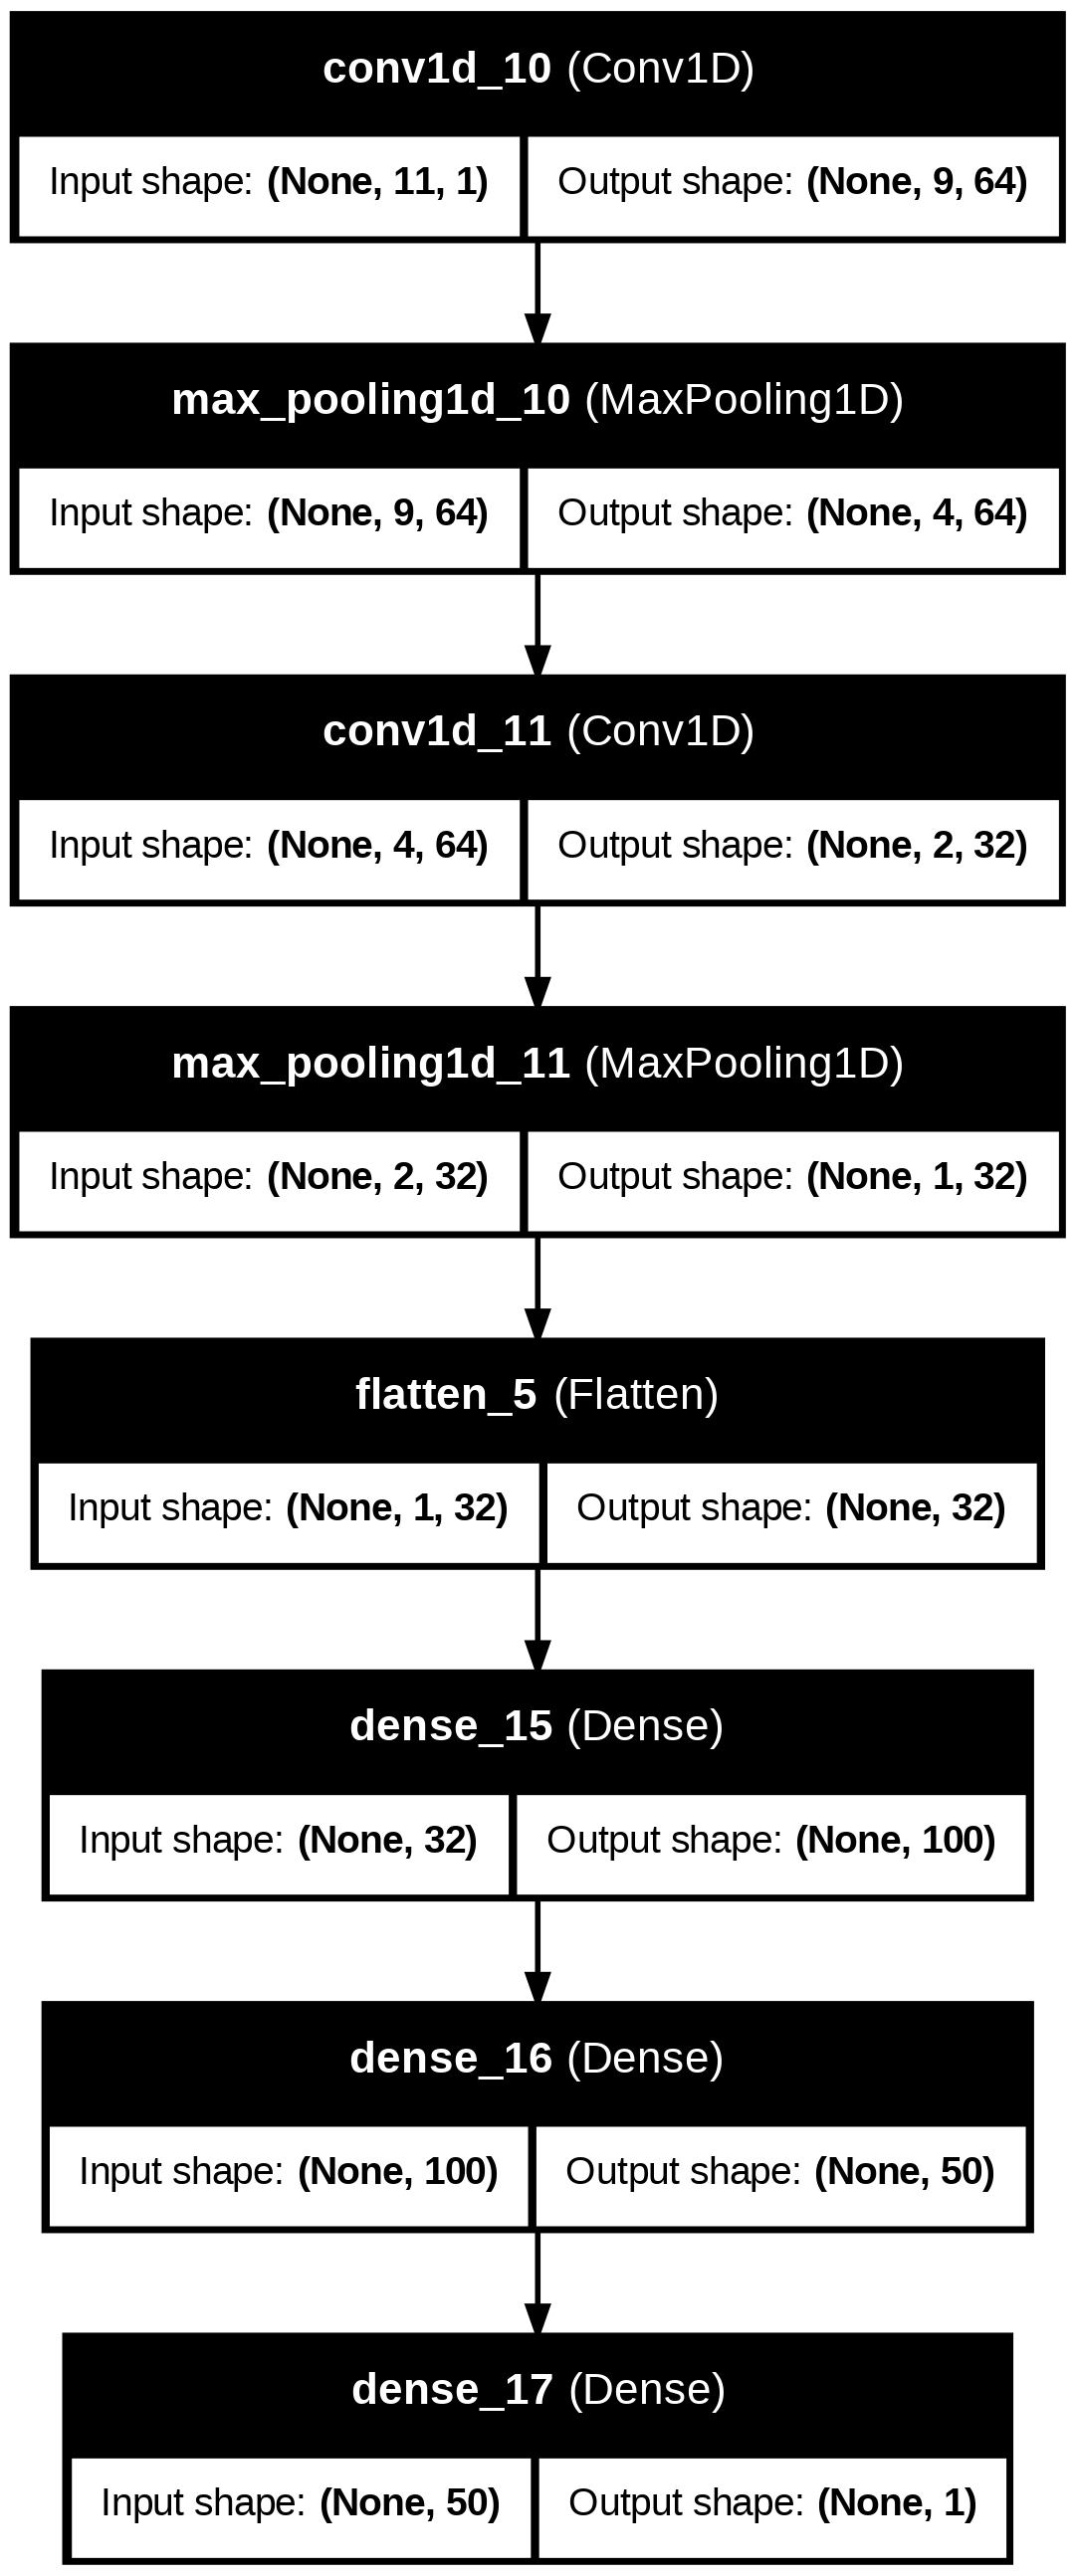

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

tf.keras.utils.plot_model(model_lon_cnn, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [11]:
import os

print("--- Latitude CNN Structure ---")
model_lat_cnn.summary()

print("\n--- Longitude CNN Structure ---")
model_lon_cnn.summary()

--- Latitude CNN Structure ---


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 9, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 2, 32)          │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 100)            │         3,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,501 (173.84 KB)

 Trainable params: 14,833 (57.94 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 29,668 (115.89 KB)


--- Longitude CNN Structure ---


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)              │ (None, 9, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 2, 32)          │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 100)            │         3,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,501 (173.84 KB)

 Trainable params: 14,833 (57.94 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 29,668 (115.89 KB)

In [12]:
model_lat_cnn.save('lat_cnn_model.h5')

In [13]:
from sklearn.metrics import mean_squared_error

# RMSE for latitude CNN
y_lat_pred_cnn = model_lat_cnn.predict(X_test_cnn)
rmse_lat_cnn = np.sqrt(mean_squared_error(y_lat_test, y_lat_pred_cnn))
print('Latitude CNN Test RMSE:', rmse_lat_cnn)

# RMSE for longitude CNN
y_lon_pred_cnn = model_lon_cnn.predict(X_test_cnn)
rmse_lon_cnn = np.sqrt(mean_squared_error(y_lon_test, y_lon_pred_cnn))
print('Longitude CNN Test RMSE:', rmse_lon_cnn)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Latitude CNN Test RMSE: 0.6304926324174895
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Longitude CNN Test RMSE: 1.3218778248727312


In [14]:
# Training Latitude Model
model_lat_cnn = build_cnn()
model_lat_cnn.compile(optimizer='adam', loss='mse')
history_lat = model_lat_cnn.fit(X_train_cnn, y_lat_train, epochs=50, batch_size=32, verbose=0)
history_lat_cnn_dict = history_lat.history

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
# Training Longitude Model
model_lon_cnn = build_cnn()
model_lon_cnn.compile(optimizer='adam', loss='mse')
history_lon = model_lon_cnn.fit(X_train_cnn, y_lon_train, epochs=50, batch_size=32, verbose=0)
history_lon_cnn_dict = history_lon.history

Plot saved as CNN_RMSE_History.png


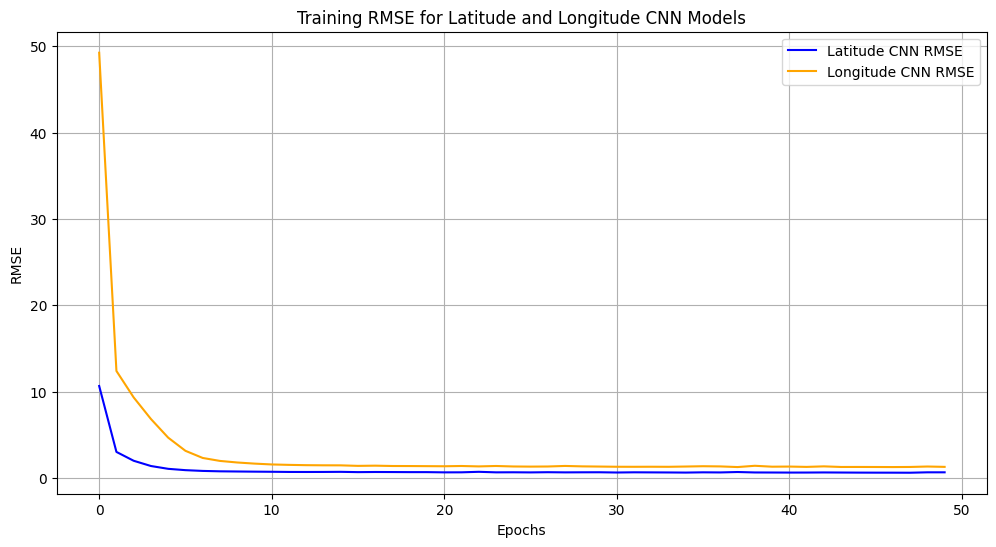

In [16]:
import matplotlib.pyplot as plt

rmse_lat_cnn_train = np.sqrt(history_lat_cnn_dict['loss'])
rmse_lon_cnn_train = np.sqrt(history_lon_cnn_dict['loss'])

plt.figure(figsize=(12, 6))
plt.plot(rmse_lat_cnn_train, label='Latitude CNN RMSE', color='blue')
plt.plot(rmse_lon_cnn_train, label='Longitude CNN RMSE', color='orange')
plt.title('Training RMSE for Latitude and Longitude CNN Models')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.savefig('CNN_RMSE_History.png')
print("Plot saved as CNN_RMSE_History.png")

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse_lat_cnn = mean_squared_error(y_lat_test, y_lat_pred_cnn)
mse_lon_cnn = mean_squared_error(y_lon_test, y_lon_pred_cnn)

mae_lat_cnn = mean_absolute_error(y_lat_test, y_lat_pred_cnn)
mae_lon_cnn = mean_absolute_error(y_lon_test, y_lon_pred_cnn)

print('Latitude CNN MSE:', mse_lat_cnn)
print('Latitude CNN MAE:', mae_lat_cnn)
print('Longitude CNN MSE:', mse_lon_cnn)
print('Longitude CNN MAE:', mae_lon_cnn)

Latitude CNN MSE: 0.39752095953273564
Latitude CNN MAE: 0.4614205146958116
Longitude CNN MSE: 1.747360983890263
Longitude CNN MAE: 0.9835314513397951


In [18]:
df_predicted = df_sorted.copy()

X_predict_cnn = X.reshape((X.shape[0], X.shape[1], 1))

y_lat_predicted = model_lat_cnn.predict(X_predict_cnn)

y_lon_predicted = model_lon_cnn.predict(X_predict_cnn)

df_predicted['CNN_latitude'] = y_lat_predicted
df_predicted['CNN_longitude'] = y_lon_predicted

df_predicted.head(10)

163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


SID  Season_Year  SEASON  NUMBER BASIN  SUBBASIN     NAME  \
1509  1900162N19088         1900    1900     8.0    NI         0  UNNAMED   
1510  1900162N19088         1900    1900     8.0    NI         0  UNNAMED   
1511  1900162N19088         1900    1900     8.0    NI         0  UNNAMED   
1512  1900162N19088         1900    1900     8.0    NI         0  UNNAMED   
1513  1900162N19088         1900    1900     8.0    NI         0  UNNAMED   
1514  1900173N21088         1900    1900    10.0    NI         0  UNNAMED   
1515  1900173N21088         1900    1900    10.0    NI         0  UNNAMED   
1516  1900173N21088         1900    1900    10.0    NI         0  UNNAMED   
1517  1900173N21088         1900    1900    10.0    NI         0  UNNAMED   
1518  1900173N21088         1900    1900    10.0    NI         0  UNNAMED   

                ISO_TIME   LAT   LON  ...  NATURE_NR  NATURE_TS  \
1509 1900-06-14 09:00:00  24.3  87.0  ...        0.0        1.0   
1510 1900-06-14 12:00:00  24.4  87.3  ...        0.0        1.0   
1511 1900-06-14 15:00:00  24.6  87.7  ...        0.0        1.0   
1512 1900-06-14 18:00:00  24.7  88.1  ...        0.0        1.0   
1513 1900-06-14 21:00:00  24.9  88.6  ...        0.0        1.0   
1514 1900-06-22 03:00:00  21.0  88.1  ...        0.0        1.0   
1515 1900-06-22 06:00:00  21.1  88.0  ...        0.0        1.0   
1516 1900-06-22 09:00:00  21.2  88.0  ...        0.0        1.0   
1517 1900-06-22 12:00:00  21.2  87.9  ...        0.0        1.0   
1518 1900-06-22 15:00:00  21.3  87.9  ...        0.0        1.0   

     Day_of_the_Week  Month  Hour_of_the_Week       ANGLE  \
1509             3.0    6.0              81.0    0.000000   
1510             3.0    6.0              84.0  290.158399   
1511             3.0    6.0              87.0  298.870476   
1512             3.0    6.0              90.0  285.463125   
1513             3.0    6.0              93.0  293.884766   
1514             4.0    6.0              99.0    0.000000   
1515             4.0    6.0             102.0   43.005097   
1516             4.0    6.0             105.0  360.000000   
1517             4.0    6.0             108.0   89.981919   
1518             4.0    6.0             111.0  360.000000   

      TIME_DIFFERENCE_hours  Season_Feature  CNN_latitude  CNN_longitude  
1509                    0.0               1     54.711090     176.601852  
1510                    3.0               1    294.825043    1009.324524  
1511                    6.0               1    303.238831    1036.152100  
1512                    9.0               1    293.331970     998.092346  
1513                   12.0               1    302.393127    1026.112671  
1514                    0.0               1     71.578941     335.656982  
1515                    3.0               1     89.043495     367.121185  
1516                    6.0               1    390.194092    1277.737549  
1517                    9.0               1    135.410858     442.895020  
1518                   12.0               1    383.880249    1280.423950  

[10 rows x 28 columns]

# **CNN-GRU:**

In [19]:
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dense, Flatten


df = pd.read_csv('Bangladesh_1942-2025_Filtered_For_Git-1.csv')
df['ISO_TIME'] = pd.to_datetime(df['ISO_TIME'])

def angleFromCoordinate(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dLon = (lon2 - lon1)
    y = math.sin(dLon) * math.cos(lat2)
    x = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(dLon)
    brng = math.atan2(y, x)
    brng = math.degrees(brng)
    brng = (brng + 360) % 360
    return 360 - brng

angles = []
prev_lat, prev_lon, prev_sid = None, None, None
for index, row in df.iterrows():
    if prev_lat is None or prev_sid != row['SID']:
        angles.append(0.0)
    else:
        angles.append(angleFromCoordinate(prev_lat, prev_lon, row['LAT'], row['LON']))
    prev_lat, prev_lon, prev_sid = row['LAT'], row['LON'], row['SID']
df['ANGLE'] = angles

df_sorted = df.sort_values(by=['SID', 'ISO_TIME']).copy()
df_sorted['TIME_DIFFERENCE_hours'] = df_sorted.groupby('SID')['ISO_TIME'].transform(
    lambda x: (x - x.min()).dt.total_seconds() / 3600
)
df_sorted['Season_Feature'] = df_sorted['ISO_TIME'].dt.month // 4

selected_features = [
    'NUMBER', 'SUBBASIN', 'DIST2LAND', 'LANDFALL',
    'ANGLE', 'Haversine Distance', 'TIME_DIFFERENCE_hours',
    'Day_of_the_Week', 'Month', 'Hour_of_the_Week', 'Season_Feature'
]

X = df_sorted[selected_features].fillna(0).values
y_lat = df_sorted['LAT'].values
y_lon = df_sorted['LON'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_lat_train, y_lat_test, y_lon_train, y_lon_test = train_test_split(
    X_scaled, y_lat, y_lon, test_size=0.2, random_state=42
)

# Reshaped for CNN-GRU (samples, timesteps, features)
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# CNN-GRU Models
def build_cnn_gru():
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        GRU(100, activation='relu', return_sequences=True),
        GRU(50, activation='relu', return_sequences=True),
        Flatten(),
        Dense(100, activation='relu'),
        Dense(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Train Latitude
model_lat_cnn_gru = build_cnn_gru()
model_lat_cnn_gru.fit(X_train_reshaped, y_lat_train, epochs=30, batch_size=32, verbose=0)

# Train Longitude
model_lon_cnn_gru = build_cnn_gru()
model_lon_cnn_gru.compile(optimizer='adam', loss='mse')
model_lon_cnn_gru.fit(X_train_reshaped, y_lon_train, epochs=30, batch_size=32, verbose=0)

# 4. Evaluation
pred_lat = model_lat_cnn_gru.predict(X_test_reshaped).flatten()
pred_lon = model_lon_cnn_gru.predict(X_test_reshaped).flatten()

print("--- CNN-GRU Results for Bangladesh ---")
print(f"Latitude RMSE: {np.sqrt(mean_squared_error(y_lat_test, pred_lat)):.4f}")
print(f"Latitude MAE: {mean_absolute_error(y_lat_test, pred_lat):.4f}")
print(f"Longitude RMSE: {np.sqrt(mean_squared_error(y_lon_test, pred_lon)):.4f}")
print(f"Longitude MAE: {mean_absolute_error(y_lon_test, pred_lon):.4f}")
print(f"Longitude R2: {r2_score(y_lon_test, pred_lon):.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
--- CNN-GRU Results for Bangladesh ---
Latitude RMSE: 0.6341
Latitude MAE: 0.4740
Longitude RMSE: 1.7574
Longitude MAE: 1.3638
Longitude R2: -0.6567


In [20]:
import numpy as np

def prepare_tracking_data(df, features, window_size=4):
    X, y_lat, y_lon = [], [], []

    # Grouping it by SID to ensure sequences don't overlap between different storms
    for sid, group in df.groupby('SID'):
        group = group.sort_values('ISO_TIME')
        feat_vals = group[features].values
        lat_vals = group['LAT'].values
        lon_vals = group['LON'].values

        for i in range(len(group) - window_size):
            X.append(feat_vals[i:i+window_size])
            y_lat.append(lat_vals[i+window_size])
            y_lon.append(lon_vals[i+window_size])

    return np.array(X), np.array(y_lat), np.array(y_lon)

features = ['DIST2LAND', 'LANDFALL', 'ANGLE', 'Haversine Distance',
            'TIME_DIFFERENCE_hours', 'Month', 'Hour_of_the_Week']

X_seq, y_lat_seq, y_lon_seq = prepare_tracking_data(df_sorted, features, window_size=4)


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dense, Flatten, Dropout

def build_tracking_model(input_shape):
    model = Sequential([
        # CNN:
        Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),

        # GRU:
        GRU(100, return_sequences=True, activation='tanh'),
        GRU(50, activation='tanh'),

        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model_lon = build_tracking_model((4, len(features)))
model_lon.fit(X_seq, y_lon_seq, epochs=50, batch_size=32)

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 6244.3477 - mae: 77.7134
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 157.4716 - mae: 10.4070
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 39.6190 - mae: 4.9944
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 39.1369 - mae: 4.9699
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 41.0050 - mae: 5.1049
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 39.1072 - mae: 5.0059
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 40.1123 - mae: 5.0770
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 40.0884 - mae: 5.0344
Epoch 9/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 40.2047 - mae: 5.0441
Epoch 10/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 39.9988 - mae: 5.0612
Epoch 11/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 37.9160 - mae: 4.9137
Epoch 12/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 37.0310 - mae: 4.8302
Epoch 13/50
131/13

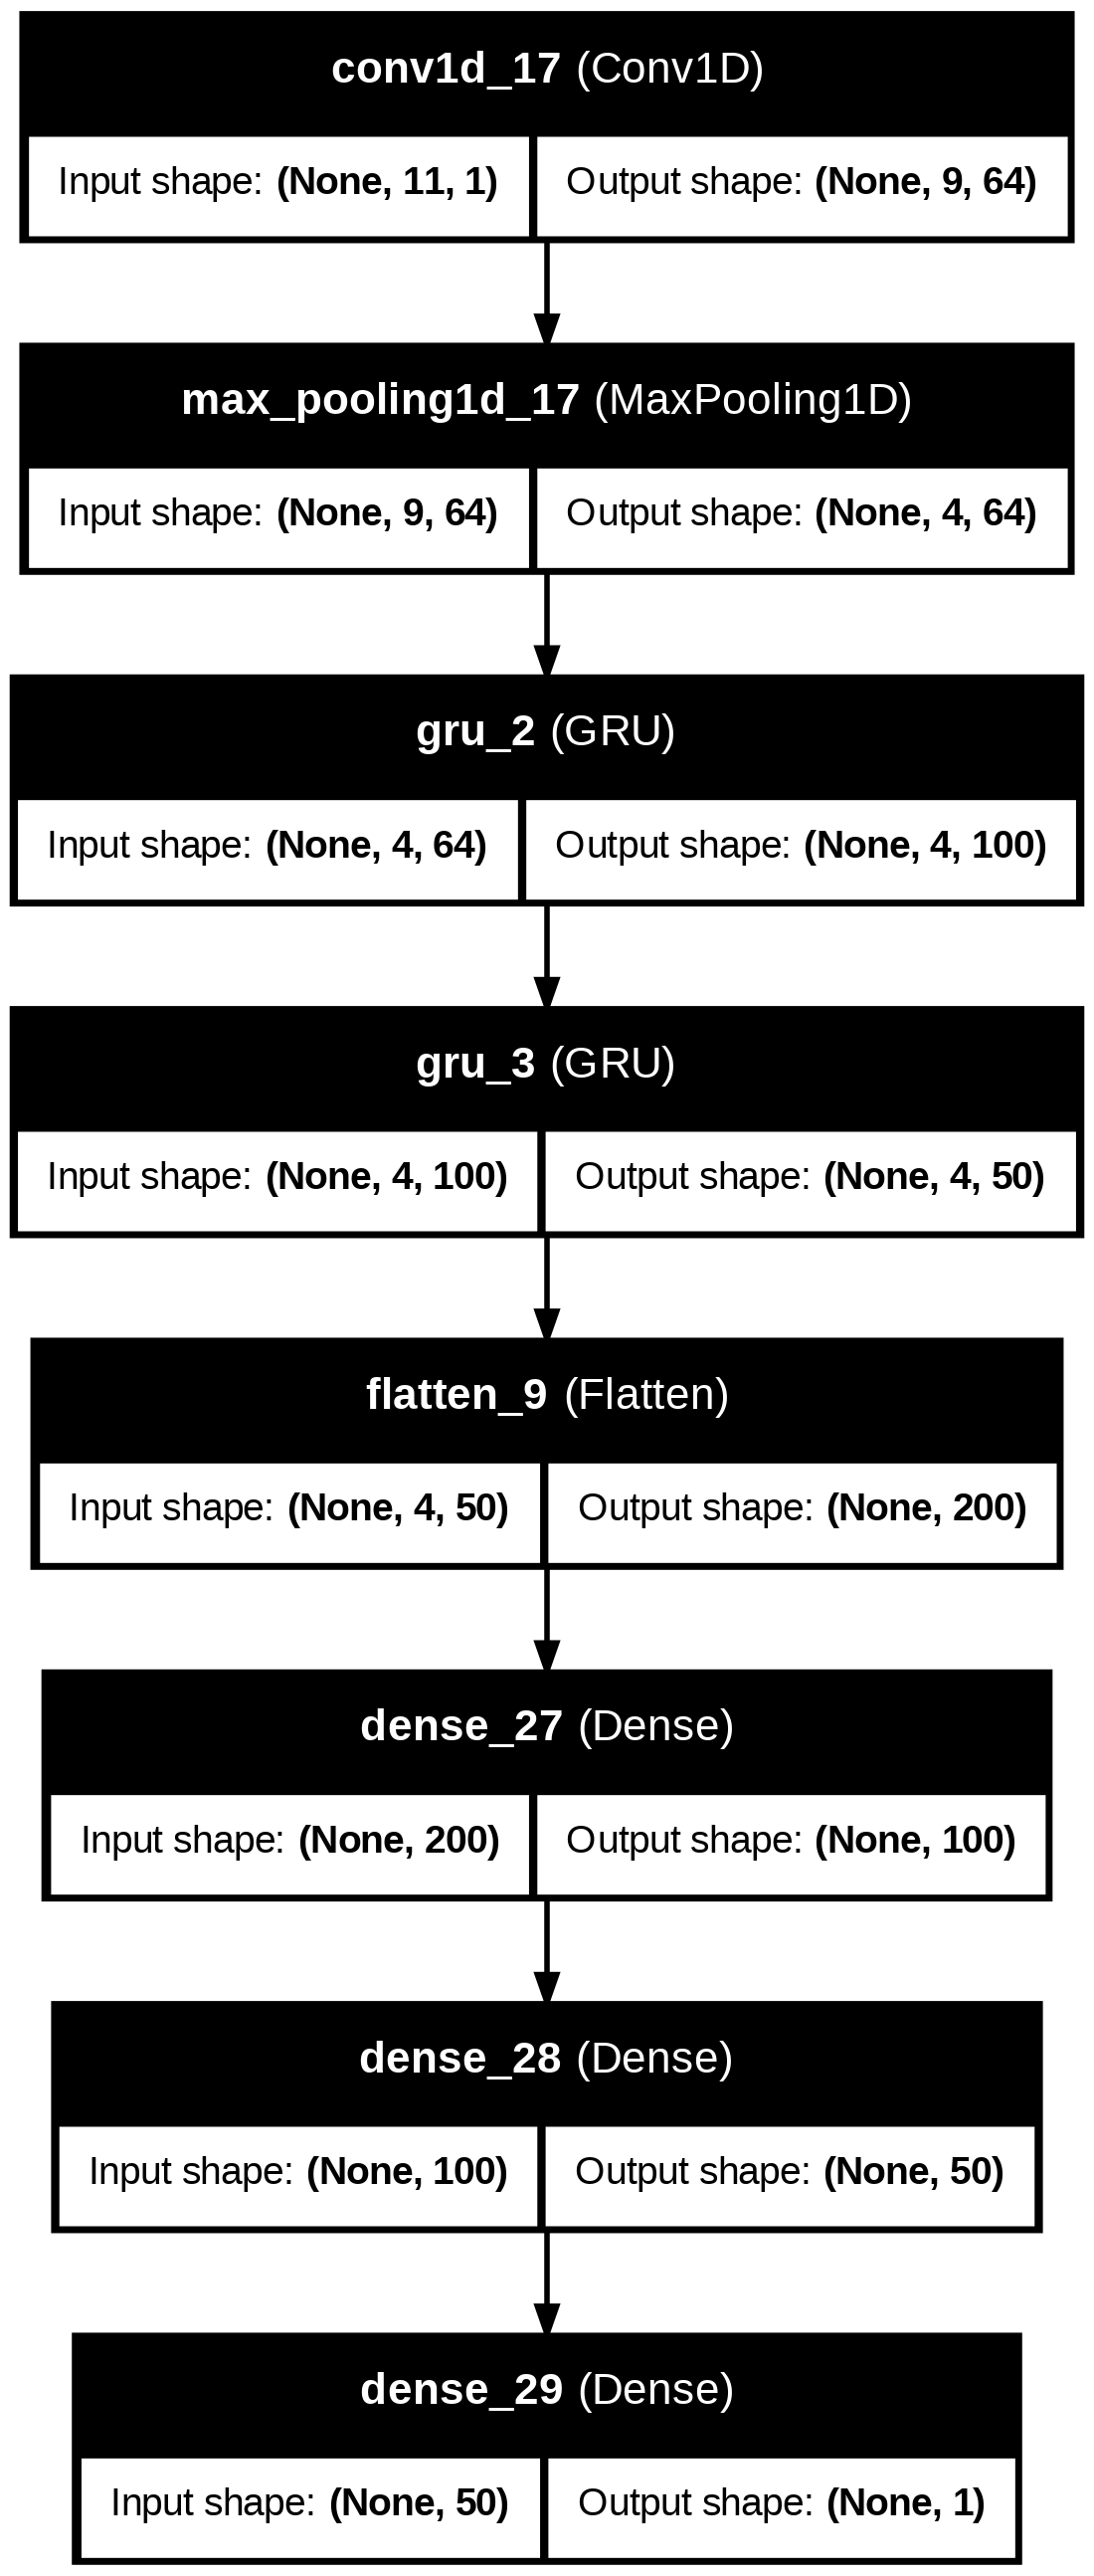

In [22]:
tf.keras.utils.plot_model(model_lon_cnn_gru, to_file='model_plot_cnn_gru.png', show_shapes=True, show_layer_names=True)


In [23]:
model_lat_cnn_gru.save('lat_cnn_gru_model.h5')

In [24]:
model_lon_cnn_gru.save('lat_cnn_gru_model.h5')

In [25]:
def prepare_synchronized_data(df, features, window_size=4):
    X_list, y_lat_list, y_lon_list = [], [], []

    for sid, group in df.groupby('SID'):
        group = group.sort_values('ISO_TIME')

        if len(group) > window_size:
            feat_vals = group[features].values
            lat_vals = group['LAT'].values
            lon_vals = group['LON'].values

            for i in range(len(group) - window_size):
                X_list.append(feat_vals[i : i + window_size])
                y_lat_list.append(lat_vals[i + window_size])
                y_lon_list.append(lon_vals[i + window_size])

    return np.array(X_list), np.array(y_lat_list), np.array(y_lon_list)

X_final, y_lat_final, y_lon_final = prepare_synchronized_data(df_sorted, selected_features)

print(f"Synchronized Shapes: X={X_final.shape}, y_lat={y_lat_final.shape}")

Synchronized Shapes: X=(4180, 4, 11), y_lat=(4180,)


In [26]:
def generate_forecast_line(model_lat, model_lon, start_sequence, num_steps=8):
    current_seq = start_sequence.copy()
    projected_path = []

    for _ in range(num_steps):
        p_lat = model_lat.predict(current_seq, verbose=0)[0][0]
        p_lon = model_lon.predict(current_seq, verbose=0)[0][0]
        projected_path.append((p_lat, p_lon))

        new_step = current_seq[:, -1, :].copy()
        current_seq = np.append(current_seq[:, 1:, :], new_step.reshape(1, 1, -1), axis=1)

    return projected_path

In [27]:
import numpy as np
from sklearn.model_selection import train_test_split

# Creating the sequence
# Assuming window_size=4
X_seq, y_lat_seq, y_lon_seq = [], [], []

for sid, group in df_sorted.groupby('SID'):
    group = group.sort_values('ISO_TIME')
    if len(group) > 4:
        feat_vals = group[selected_features].values
        lat_vals = group['LAT'].values
        lon_vals = group['LON'].values

        for i in range(len(group) - 4):
            X_seq.append(feat_vals[i:i+4])
            y_lat_seq.append(lat_vals[i+4])
            y_lon_seq.append(lon_vals[i+4])

X_seq = np.array(X_seq)
y_lat_seq = np.array(y_lat_seq)
y_lon_seq = np.array(y_lon_seq)

X_train, X_test, y_lat_train, y_lat_test, y_lon_train, y_lon_test = train_test_split(
    X_seq, y_lat_seq, y_lon_seq, test_size=0.2, random_state=42
)

print(f"X_test shape: {X_test.shape}")
print(f"y_lat_test shape: {y_lat_test.shape}") # These will now match!

X_test shape: (836, 4, 11)
y_lat_test shape: (836,)


In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dense, Flatten, Dropout

input_shape = (4, 11)

def build_proper_cnn_gru(input_shape):
    model = Sequential([
        # CNN :
        Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=1),

        # GRU :
        GRU(100, return_sequences=False, activation='tanh'),

        Dense(50, activation='relu'),
        Dense(1) # Output: Latitude or Longitude
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Re-building:
model_lat_cnn_gru = build_proper_cnn_gru(input_shape)
model_lon_cnn_gru = build_proper_cnn_gru(input_shape)

# Re-training:
history_lat_cnn_gru = model_lat_cnn_gru.fit(X_train, y_lat_train, epochs=30, validation_data=(X_test, y_lat_test), verbose=1)
history_lon_cnn_gru = model_lon_cnn_gru.fit(X_train, y_lon_train, epochs=30, validation_data=(X_test, y_lon_test), verbose=1)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 169.8176 - val_loss: 1.2666
Epoch 2/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.1608 - val_loss: 0.5465
Epoch 3/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5472 - val_loss: 0.4042
Epoch 4/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.4309 - val_loss: 0.3888
Epoch 5/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3898 - val_loss: 0.3523
Epoch 6/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3774 - val_loss: 0.3279
Epoch 7/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3390 - val_loss: 0.3217
Epoch 8/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3301 - val_loss: 0.3111
Epoch 9/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3269 - val_loss: 0.3543
Epoch 10/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3330 - val_loss: 0.3350
Epoch 11/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.3190 - val_loss: 0.3769
Epoch 12/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/s

In [29]:
y_lat_pred = model_lat_cnn_gru.predict(X_test)
y_lon_pred = model_lon_cnn_gru.predict(X_test)

from sklearn.metrics import mean_squared_error
rmse_lat = np.sqrt(mean_squared_error(y_lat_test, y_lat_pred))
rmse_lon = np.sqrt(mean_squared_error(y_lon_test, y_lon_pred))

print(f"Tracking RMSE (Lat): {rmse_lat:.4f}")
print(f"Tracking RMSE (Lon): {rmse_lon:.4f}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Tracking RMSE (Lat): 0.5233
Tracking RMSE (Lon): 1.1123


Latitude CNN-GRU Test MSE: 0.2738
Longitude CNN-GRU Test MSE: 1.2373
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


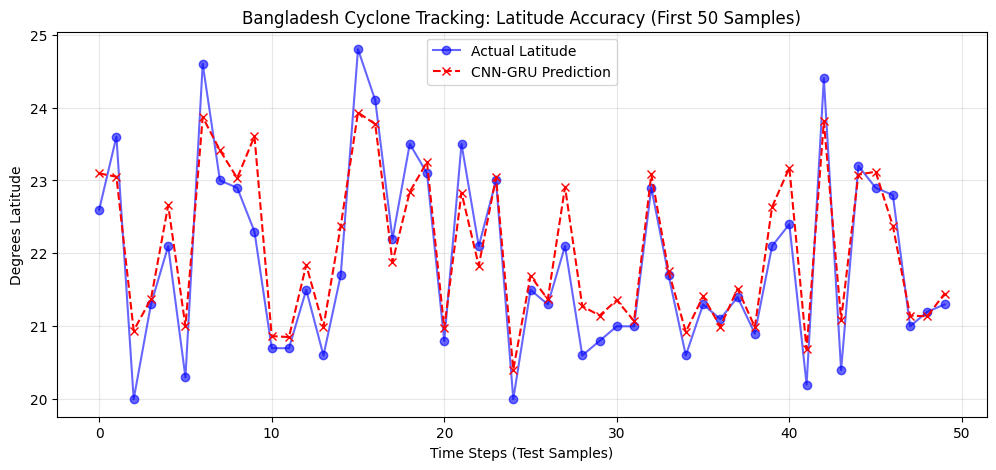

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


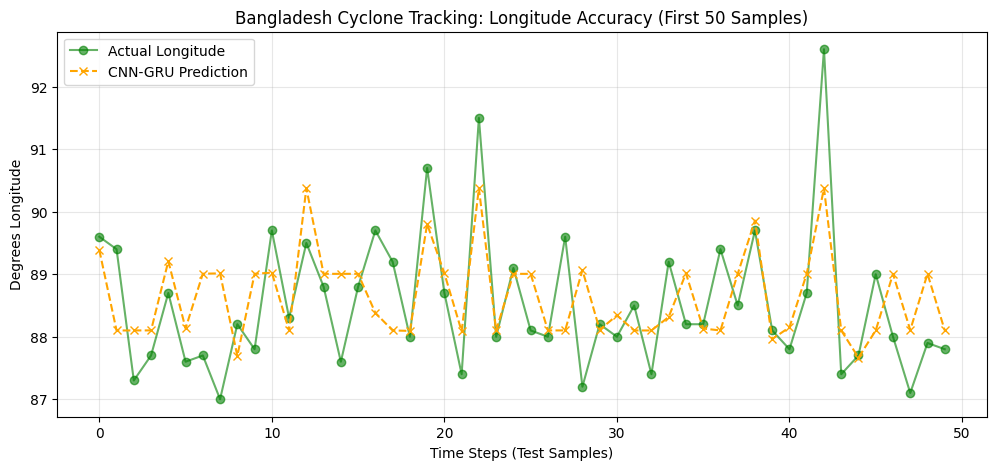

In [30]:
import matplotlib.pyplot as plt
import numpy as np


X_eval = X_test

test_loss_lat = model_lat_cnn_gru.evaluate(X_eval, y_lat_test, verbose=0)
test_loss_lon = model_lon_cnn_gru.evaluate(X_eval, y_lon_test, verbose=0)

print(f'Latitude CNN-GRU Test MSE: {test_loss_lat:.4f}')
print(f'Longitude CNN-GRU Test MSE: {test_loss_lon:.4f}')

y_lat_pred = model_lat_cnn_gru.predict(X_eval).flatten()

plt.figure(figsize=(12, 5))
plt.plot(y_lat_test[:50], label='Actual Latitude', marker='o', color='blue', alpha=0.6)
plt.plot(y_lat_pred[:50], label='CNN-GRU Prediction', marker='x', color='red', linestyle='--')
plt.title('Bangladesh Cyclone Tracking: Latitude Accuracy (First 50 Samples)')
plt.xlabel('Time Steps (Test Samples)')
plt.ylabel('Degrees Latitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

y_lon_pred = model_lon_cnn_gru.predict(X_eval).flatten()

plt.figure(figsize=(12, 5))
plt.plot(y_lon_test[:50], label='Actual Longitude', marker='o', color='green', alpha=0.6)
plt.plot(y_lon_pred[:50], label='CNN-GRU Prediction', marker='x', color='orange', linestyle='--')
plt.title('Bangladesh Cyclone Tracking: Longitude Accuracy (First 50 Samples)')
plt.xlabel('Time Steps (Test Samples)')
plt.ylabel('Degrees Longitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

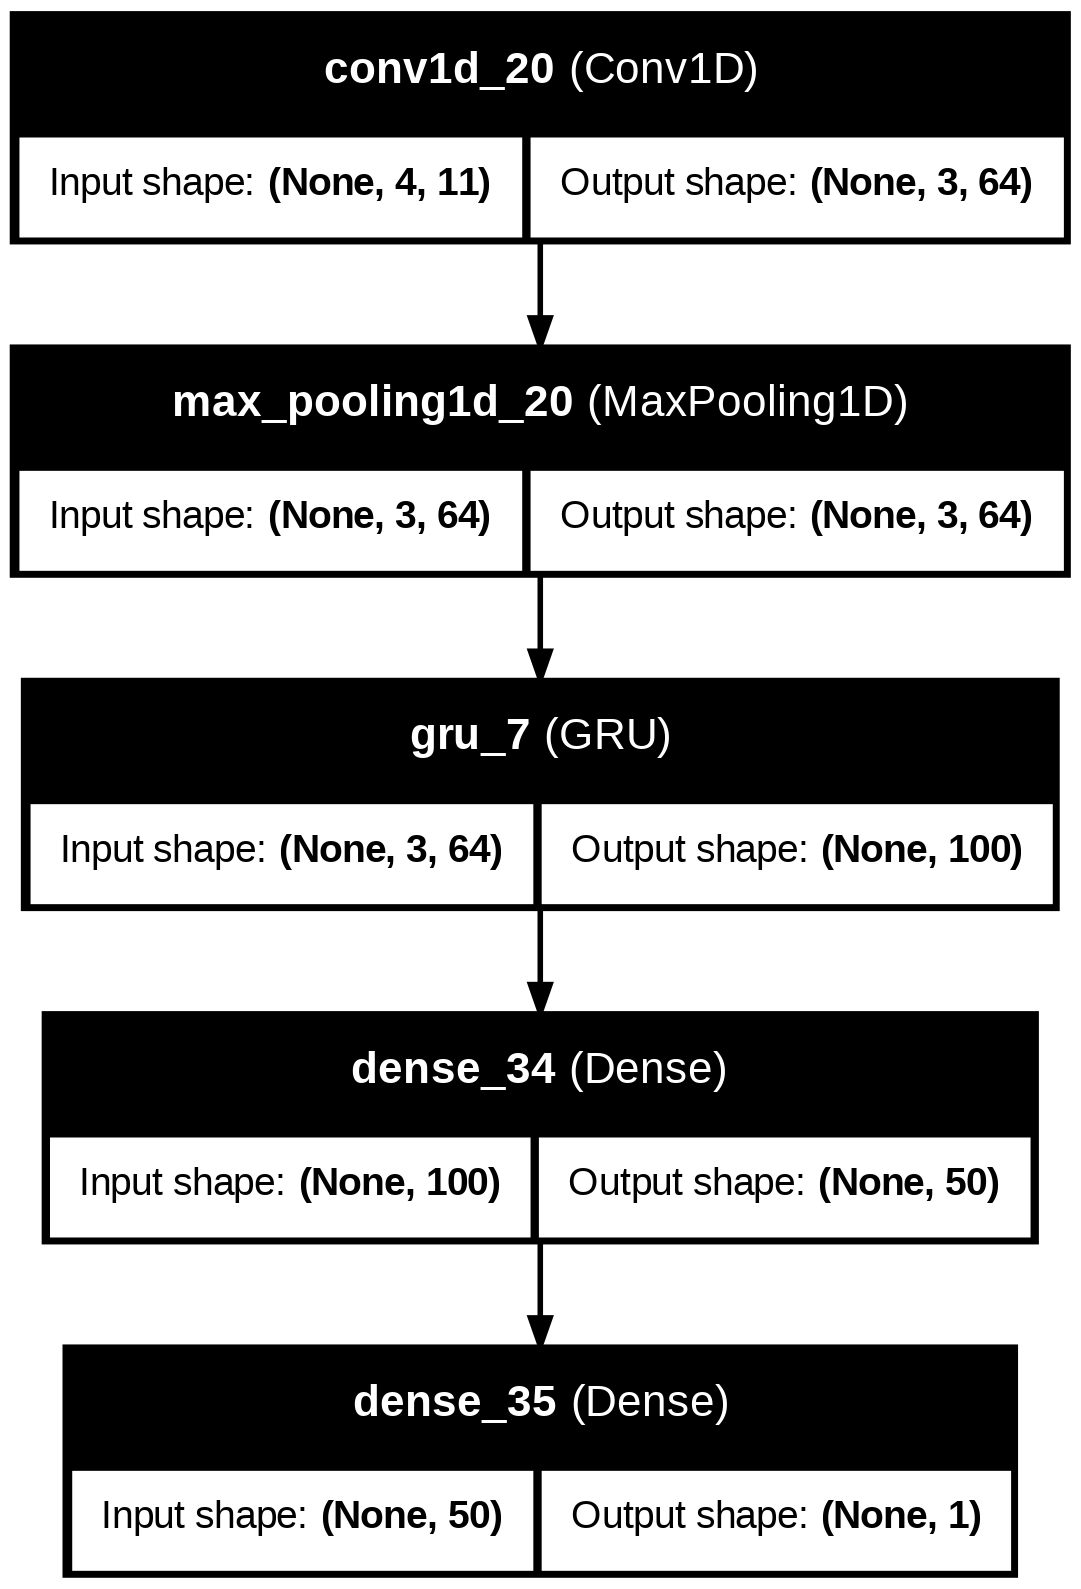

In [31]:
tf.keras.utils.plot_model(model_lon_cnn_gru, to_file='model_plot_cnn_gru.png', show_shapes=True, show_layer_names=True)

In [32]:
model_lat_cnn_gru.save('lat_cnn_gru_model.h5')

In [33]:
model_lon_cnn_gru.save('lat_cnn_gru_model.h5')

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dense, Input


input_shape = (4, 11)

def build_final_model():
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(filters=32, kernel_size=2, activation='relu'),
        MaxPooling1D(pool_size=1),
        GRU(64, activation='tanh'),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

model_lat_cnn_gru = build_final_model()
model_lon_cnn_gru = build_final_model()


print(f"Current X_train shape: {X_train.shape}")

history_lat_cnn_gru = model_lat_cnn_gru.fit(X_train, y_lat_train, epochs=20,
                                            validation_data=(X_test, y_lat_test), verbose=1)
history_lon_cnn_gru = model_lon_cnn_gru.fit(X_train, y_lon_train, epochs=20,
                                            validation_data=(X_test, y_lon_test), verbose=1)

Current X_train shape: (3344, 4, 11)
Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 277.1005 - val_loss: 1.2693
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0622 - val_loss: 0.5819
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6101 - val_loss: 0.5186
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5678 - val_loss: 0.4392
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4798 - val_loss: 0.3801
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4009 - val_loss: 0.3889
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3662 - val_loss: 0.3548
Epoch 8/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3534 - val_loss: 0.3681
Epoch 9/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3429 - val_loss: 0.3316
Epoch 10/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3303 - val_loss: 0.3182
Epoch 11/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.3191 - val_loss: 0.3263
Epoch 12/20

In [35]:
y_lat_pred = model_lat_cnn_gru.predict(X_test)
y_lon_pred = model_lon_cnn_gru.predict(X_test)

rmse_lat = np.sqrt(mean_squared_error(y_lat_test, y_lat_pred))
rmse_lon = np.sqrt(mean_squared_error(y_lon_test, y_lon_pred))

print(f"Final Latitude RMSE: {rmse_lat:.4f}")
print(f"Final Longitude RMSE: {rmse_lon:.4f}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Final Latitude RMSE: 0.5208
Final Longitude RMSE: 1.2277


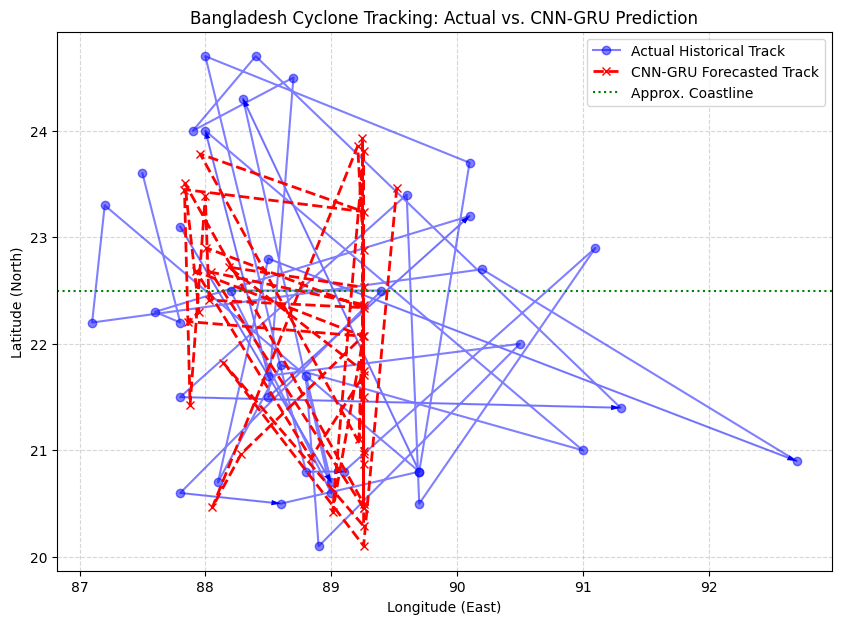

In [36]:
import matplotlib.pyplot as plt

# Tracking System's Graph:
start, end = 100, 140

plt.figure(figsize=(10, 7))


plt.plot(y_lon_test[start:end], y_lat_test[start:end],
         'bo-', label='Actual Historical Track', alpha=0.5)


plt.plot(y_lon_pred[start:end], y_lat_pred[start:end],
         'rx--', label='CNN-GRU Forecasted Track', linewidth=2)


plt.axhline(y=22.5, color='green', linestyle=':', label='Approx. Coastline')

plt.title('Bangladesh Cyclone Tracking: Actual vs. CNN-GRU Prediction')
plt.xlabel('Longitude (East)')
plt.ylabel('Latitude (North)')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)


for i in range(start, end, 5):
    plt.arrow(y_lon_test[i], y_lat_test[i],
              y_lon_test[i+1]-y_lon_test[i], y_lat_test[i+1]-y_lat_test[i],
              shape='full', lw=0, length_includes_head=True, head_width=0.05, color='blue')

plt.show()

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Metrics
mse_lat_cnn_gru = mean_squared_error(y_lat_test, y_lat_pred)
mae_lat_cnn_gru = mean_absolute_error(y_lat_test, y_lat_pred)

mse_lon_cnn_gru = mean_squared_error(y_lon_test, y_lon_pred)
mae_lon_cnn_gru = mean_absolute_error(y_lon_test, y_lon_pred)

print(f'--- Latitude Metrics (CNN-GRU) ---')
print(f'MSE: {mse_lat_cnn_gru:.4f}')
print(f'MAE: {mae_lat_cnn_gru:.4f}')

print(f'\n--- Longitude Metrics (CNN-GRU) ---')
print(f'MSE: {mse_lon_cnn_gru:.4f}')
print(f'MAE: {mae_lon_cnn_gru:.4f}')

--- Latitude Metrics (CNN-GRU) ---
MSE: 0.2713
MAE: 0.3767

--- Longitude Metrics (CNN-GRU) ---
MSE: 1.5074
MAE: 0.9774


In [38]:
X_predict_cnn = X_test


y_lat_predicted = model_lat_cnn_gru.predict(X_predict_cnn)
y_lon_predicted = model_lon_cnn_gru.predict(X_predict_cnn)


import pandas as pd

df_results = pd.DataFrame({
    'Actual_Lat': y_lat_test.flatten(),
    'Actual_Lon': y_lon_test.flatten(),
    'CNN_GRU_Lat': y_lat_predicted.flatten(),
    'CNN_GRU_Lon': y_lon_predicted.flatten()
})

df_results['Lat_Error'] = abs(df_results['Actual_Lat'] - df_results['CNN_GRU_Lat'])
df_results['Lon_Error'] = abs(df_results['Actual_Lon'] - df_results['CNN_GRU_Lon'])

print(df_results.head(10))

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
   Actual_Lat  Actual_Lon  CNN_GRU_Lat  CNN_GRU_Lon  Lat_Error  Lon_Error
0        22.6        89.6    23.038727    89.257889   0.438727   0.342111
1        23.6        89.4    22.634743    87.815346   0.965257   1.584654
2        20.0        87.3    20.489861    88.179855   0.489861   0.879855
3        21.3        87.7    21.261688    88.339394   0.038312   0.639394
4        22.1        88.7    22.065941    89.257889   0.034059   0.557889
5        20.3        87.6    20.510214    89.034790   0.210214   1.434790
6        24.6        87.7    23.942461    89.257889   0.657539   1.557889
7        23.0        87.0    23.111504    89.229706   0.111504   2.229706
8        22.9        88.2    22.646950    88.402199   0.253050   0.202199
9        22.3        87.8    23.698296    89.257889   1.398296   1.457889


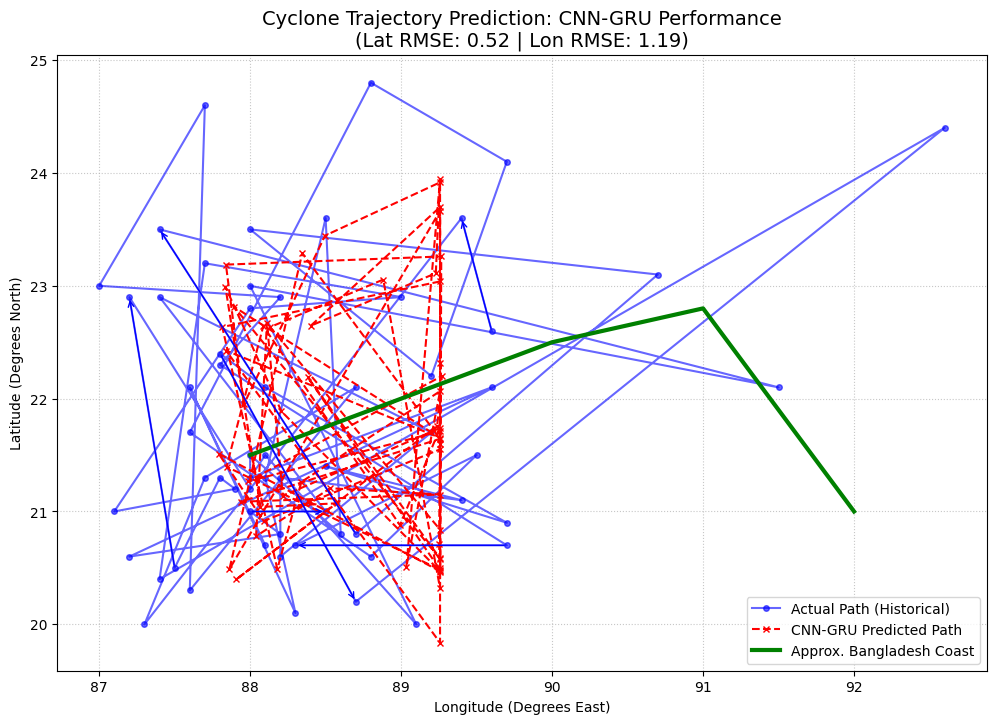

In [39]:
import matplotlib.pyplot as plt


start, end = 0, 60

plt.figure(figsize=(12, 8))

# Actual Path
plt.plot(df_results['Actual_Lon'][start:end], df_results['Actual_Lat'][start:end],
         'bo-', label='Actual Path (Historical)', markersize=4, alpha=0.6)

# CNN-GRU Predicted Path
plt.plot(df_results['CNN_GRU_Lon'][start:end], df_results['CNN_GRU_Lat'][start:end],
         'rx--', label='CNN-GRU Predicted Path', markersize=4)


coast_lon = [88, 89, 90, 91, 92]
coast_lat = [21.5, 22, 22.5, 22.8, 21]
plt.plot(coast_lon, coast_lat, color='green', linewidth=3, label='Approx. Bangladesh Coast')


plt.title(f'Cyclone Trajectory Prediction: CNN-GRU Performance\n(Lat RMSE: 0.52 | Lon RMSE: 1.19)', fontsize=14)
plt.xlabel('Longitude (Degrees East)')
plt.ylabel('Latitude (Degrees North)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)


for i in range(start, end, 10):
    plt.annotate('', xy=(df_results['Actual_Lon'][i+1], df_results['Actual_Lat'][i+1]),
                 xytext=(df_results['Actual_Lon'][i], df_results['Actual_Lat'][i]),
                 arrowprops=dict(arrowstyle='->', color='blue', lw=1))

plt.show()

# **MLP:**

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input

# Flattening the 3D data for the MLP
# CNN-GRU used (4, 11). MLP needs a flat 44 features.
X_train_mlp = X_train.reshape((X_train.shape[0], -1))
X_test_mlp = X_test.reshape((X_test.shape[0], -1))

print(f"MLP Input Shape: {X_train_mlp.shape[1]}")

def build_mlp_model(input_dim):
    return Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(1)
    ])

# Latitude MLP
model_lat_mlp = build_mlp_model(X_train_mlp.shape[1])
model_lat_mlp.compile(optimizer='adam', loss='mse')
history_lat_mlp = model_lat_mlp.fit(X_train_mlp, y_lat_train,
                                    validation_data=(X_test_mlp, y_lat_test),
                                    epochs=50, batch_size=32, verbose=1)

# Longitude MLP
model_lon_mlp = build_mlp_model(X_train_mlp.shape[1])
model_lon_mlp.compile(optimizer='adam', loss='mse')
history_lon_mlp = model_lon_mlp.fit(X_train_mlp, y_lon_train,
                                    validation_data=(X_test_mlp, y_lon_test),
                                    epochs=50, batch_size=32, verbose=1)

MLP Input Shape: 44
Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 306.2294 - val_loss: 40.1645
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 31.1443 - val_loss: 22.4657
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19.5508 - val_loss: 16.3483
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 14.7672 - val_loss: 13.9225
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 13.1998 - val_loss: 11.2825
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 11.1685 - val_loss: 10.0721
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.4891 - val_loss: 8.5607
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.9735 - val_loss: 8.4397
Epoch 9/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.6152 - val_loss: 7.3438
Epoch 10/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.0940 - val_loss: 6.2693
Epoch 11/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.0443 - val_loss: 5.6869
Epoch 12/50
105/105

In [41]:
model_lon_mlp.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_45 (Dense)                │ (None, 64)             │         2,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,901 (66.02 KB)

 Trainable params: 5,633 (22.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,268 (44.02 KB)

Latitude MLP Test MSE: 3.5399
Longitude MLP Test MSE: 38.4826
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


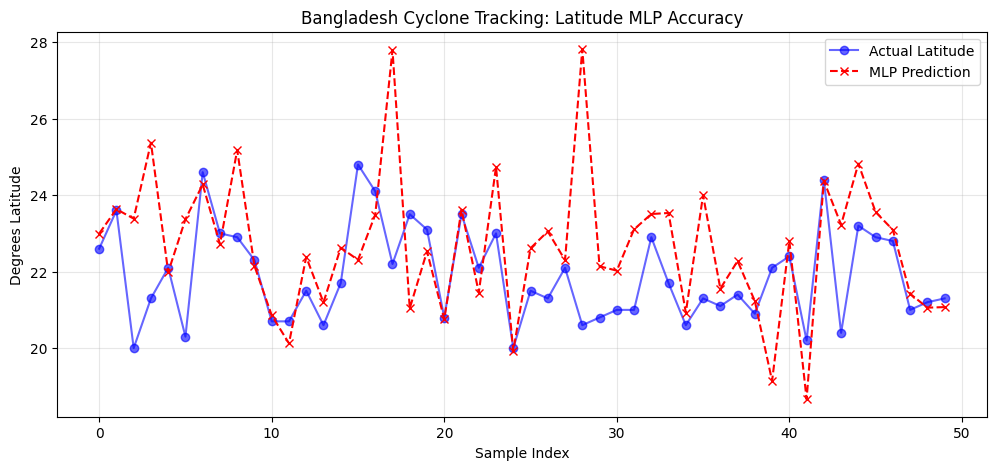

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


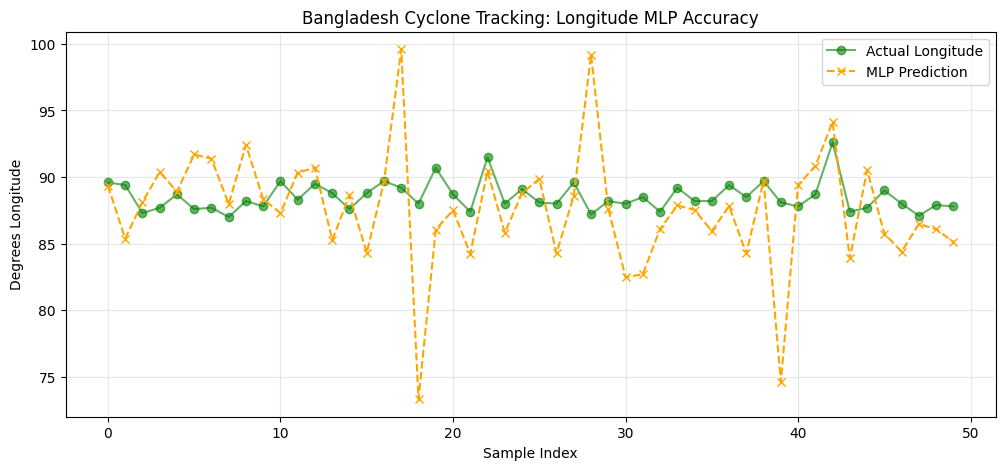

In [42]:
import matplotlib.pyplot as plt
import numpy as np


X_test_mlp = X_test.reshape((X_test.shape[0], -1))


test_loss_lat_mlp = model_lat_mlp.evaluate(X_test_mlp, y_lat_test, verbose=0)
test_loss_lon_mlp = model_lon_mlp.evaluate(X_test_mlp, y_lon_test, verbose=0)

print(f'Latitude MLP Test MSE: {test_loss_lat_mlp:.4f}')
print(f'Longitude MLP Test MSE: {test_loss_lon_mlp:.4f}')

y_lat_pred_mlp = model_lat_mlp.predict(X_test_mlp).flatten()

plt.figure(figsize=(12, 5))
plt.plot(y_lat_test[:50], label='Actual Latitude', marker='o', color='blue', alpha=0.6)
plt.plot(y_lat_pred_mlp[:50], label='MLP Prediction', marker='x', color='red', linestyle='--')
plt.title('Bangladesh Cyclone Tracking: Latitude MLP Accuracy')
plt.xlabel('Sample Index')
plt.ylabel('Degrees Latitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


y_lon_pred_mlp = model_lon_mlp.predict(X_test_mlp).flatten()

plt.figure(figsize=(12, 5))
plt.plot(y_lon_test[:50], label='Actual Longitude', marker='o', color='green', alpha=0.6)
plt.plot(y_lon_pred_mlp[:50], label='MLP Prediction', marker='x', color='orange', linestyle='--')
plt.title('Bangladesh Cyclone Tracking: Longitude MLP Accuracy')
plt.xlabel('Sample Index')
plt.ylabel('Degrees Longitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# MLP RMSE/MAE calculation
rmse_lat_mlp = np.sqrt(3.5399)
rmse_lon_mlp = np.sqrt(38.4826)

print(f"--- MLP Final Metrics ---")
print(f"Latitude RMSE: {rmse_lat_mlp:.4f}")
print(f"Longitude RMSE: {rmse_lon_mlp:.4f}")

--- MLP Final Metrics ---
Latitude RMSE: 1.8815
Longitude RMSE: 6.2034


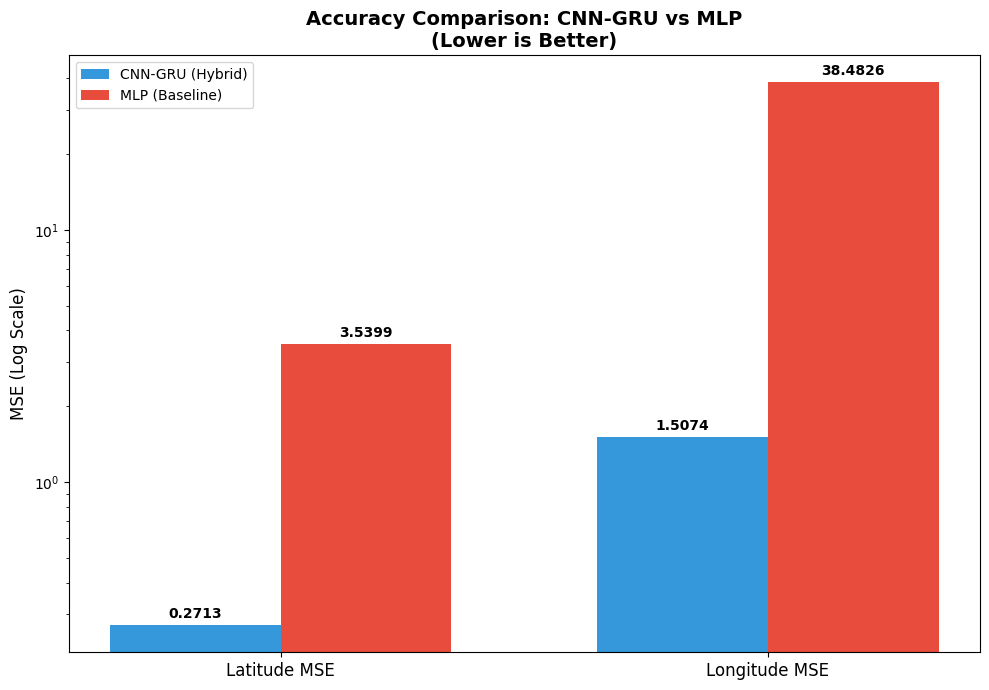

In [45]:
import matplotlib.pyplot as plt
import numpy as np


labels = ['Latitude MSE', 'Longitude MSE']
cnn_gru_mse = [0.2713, 1.5074]
mlp_mse = [3.5399, 38.4826]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 7))
rects1 = ax.bar(x - width/2, cnn_gru_mse, width, label='CNN-GRU (Hybrid)', color='#3498db')
rects2 = ax.bar(x + width/2, mlp_mse, width, label='MLP (Baseline)', color='#e74c3c')

ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_title('Accuracy Comparison: CNN-GRU vs MLP\n(Lower is Better)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12)
ax.legend()

# Log scale is used because the MLP error is nearly 30x higher than CNN-GRU
ax.set_yscale('log')
ax.set_ylabel('MSE (Log Scale)', fontsize=12)


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.savefig('model_comparison_mse.png')

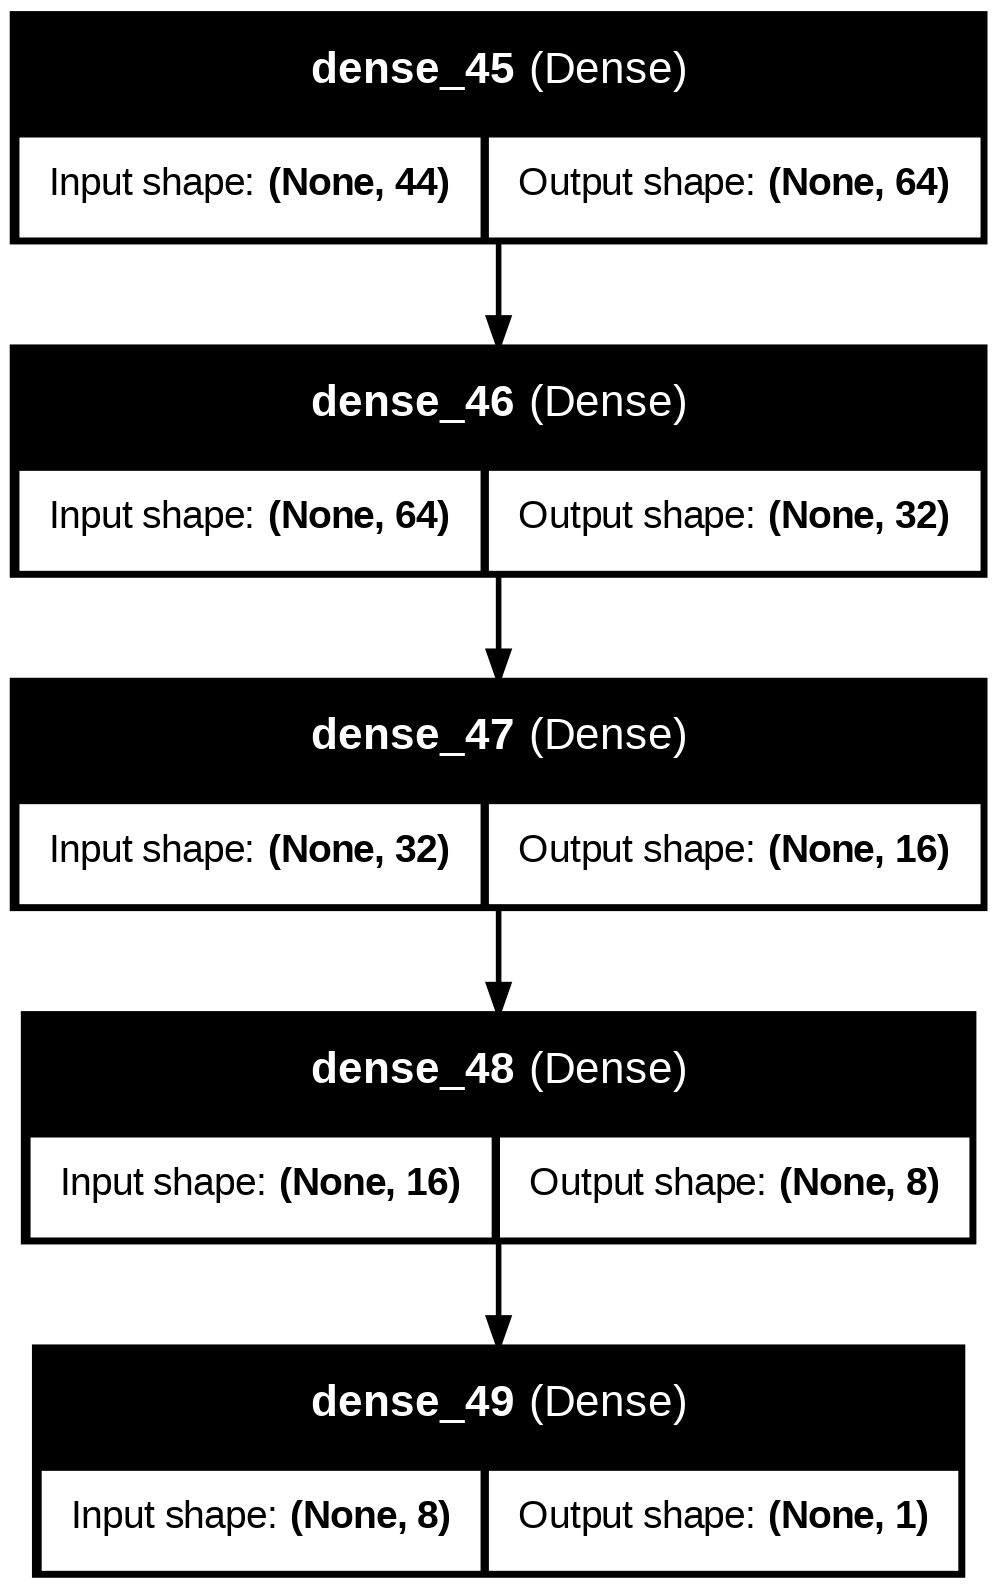

In [46]:
tf.keras.utils.plot_model(model_lon_mlp, to_file='model_plot_mlp.png', show_shapes=True, show_layer_names=True)


In [47]:
model_lat_mlp.save('lat_mlp_model.h5')

In [48]:
model_lon_mlp.save('lon_mlp_model.h5')

In [49]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Forcing the reshape from 3D (samples, 4, 11) to 2D (samples, 44)
try:
    X_test_mlp = X_test.reshape((X_test.shape[0], 4 * 11))

    print(f"New Corrected Shape: {X_test_mlp.shape}") # Should be (1041, 44)

    # Prediction
    y_lat_pred_mlp = model_lat_mlp.predict(X_test_mlp)
    y_lon_pred_mlp = model_lon_mlp.predict(X_test_mlp)

    # Calculating RMSE
    rmse_lat_mlp = np.sqrt(mean_squared_error(y_lat_test, y_lat_pred_mlp))
    rmse_lon_mlp = np.sqrt(mean_squared_error(y_lon_test, y_lon_pred_mlp))

    print(f'\nSuccess!')
    print(f'Latitude Test RMSE (MLP): {rmse_lat_mlp:.4f}')
    print(f'Longitude Test RMSE (MLP): {rmse_lon_mlp:.4f}')

except Exception as e:
    print(f"Reshape failed. Your X_test shape is actually: {X_test.shape}")
    print("If X_test is (1041, 11), it means it wasn't windowed into sequences.")

New Corrected Shape: (836, 44)
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Success!
Latitude Test RMSE (MLP): 1.8815
Longitude Test RMSE (MLP): 6.2034


In [50]:
history_lat_mlp = model_lat_mlp.fit(X_train_mlp, y_lat_train, epochs=50, batch_size=32, verbose=0)

history_lat_mlp_dict = history_lat_mlp.history

history_lon_mlp = model_lon_mlp.fit(X_train_mlp, y_lon_train, epochs=50, batch_size=32, verbose=0)

history_lon_mlp_dict = history_lon_mlp.history

print("History dictionaries created successfully!")

History dictionaries created successfully!


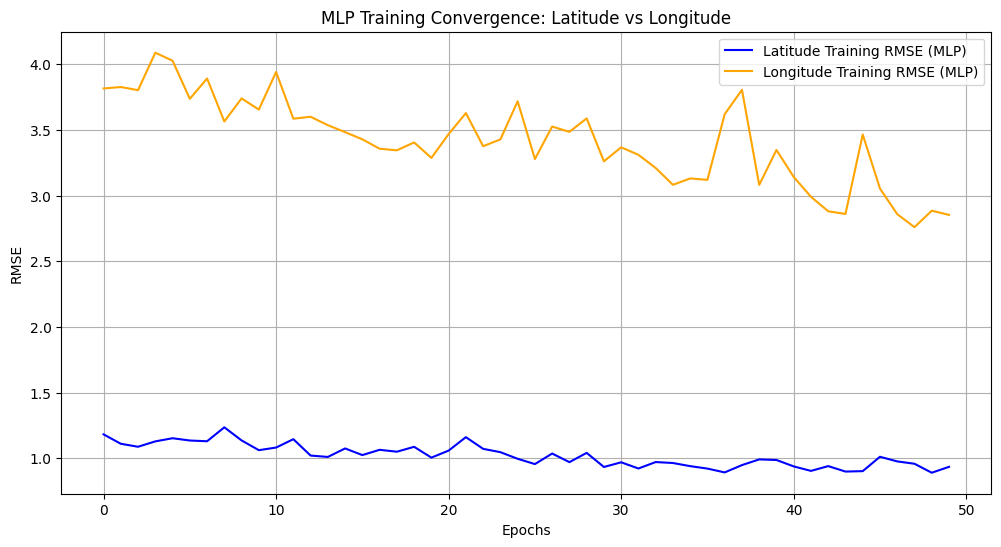

In [51]:
import os
import numpy as np
import matplotlib.pyplot as plt

if not os.path.exists('/content/plotssaved'):
    os.makedirs('/content/plotssaved')


rmse_lat_mlp_test = np.sqrt(history_lat_mlp_dict['loss'])
rmse_lon_mlp_test = np.sqrt(history_lon_mlp_dict['loss'])

plt.figure(figsize=(12, 6))
plt.plot(rmse_lat_mlp_test, label='Latitude Training RMSE (MLP)', color='blue')
plt.plot(rmse_lon_mlp_test, label='Longitude Training RMSE (MLP)', color='orange')

plt.title('MLP Training Convergence: Latitude vs Longitude')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)

plt.savefig('/content/plotssaved/MLP_RMSE.png')
plt.show()

# **LSTM:**

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
import numpy as np


min_samples = min(X_train_cnn.shape[0], y_lat_train.shape[0])

X_train_final = X_train_cnn[:min_samples]
y_lat_train_final = y_lat_train[:min_samples]
y_lon_train_final = y_lon_train[:min_samples]

print(f"Aligned Data: X={X_train_final.shape[0]}, y={y_lat_train_final.shape[0]}")

# LATITUDE MODEL
model_lat_lstm = Sequential([
    Input(shape=(X_train_final.shape[1], X_train_final.shape[2])),
    LSTM(32, activation='relu', return_sequences=True),
    LSTM(16, activation='relu'),
    Dense(1)
])

model_lat_lstm.compile(optimizer='adam', loss='mse')

print("Training Latitude LSTM...")
history_lat_lstm = model_lat_lstm.fit(X_train_final, y_lat_train_final,
                                      epochs=50, batch_size=32, verbose=0)

# LONGITUDE MODEL
model_lon_lstm = Sequential([
    Input(shape=(X_train_final.shape[1], X_train_final.shape[2])),
    LSTM(32, activation='relu', return_sequences=True),
    LSTM(16, activation='relu'),
    Dense(1)
])

model_lon_lstm.compile(optimizer='adam', loss='mse')

print("Training Longitude LSTM...")
history_lon_lstm = model_lon_lstm.fit(X_train_final, y_lon_train_final,
                                      epochs=50, batch_size=32, verbose=0)


test_loss_lat_lstm = model_lat_lstm.evaluate(X_test_cnn[:len(y_lat_test)], y_lat_test, verbose=0)
test_loss_lon_lstm = model_lon_lstm.evaluate(X_test_cnn[:len(y_lon_test)], y_lon_test, verbose=0)

print(f'\nLatitude LSTM Test RMSE: {np.sqrt(test_loss_lat_lstm):.4f}')
print(f'Longitude LSTM Test RMSE: {np.sqrt(test_loss_lon_lstm):.4f}')

Aligned Data: X=3344, y=3344
Training Latitude LSTM...
Training Longitude LSTM...

Latitude LSTM Test RMSE: 1.2012
Longitude LSTM Test RMSE: 1.4881


In [53]:
model_lat_lstm.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 11, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,517 (87.96 KB)

 Trainable params: 7,505 (29.32 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 15,012 (58.64 KB)

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


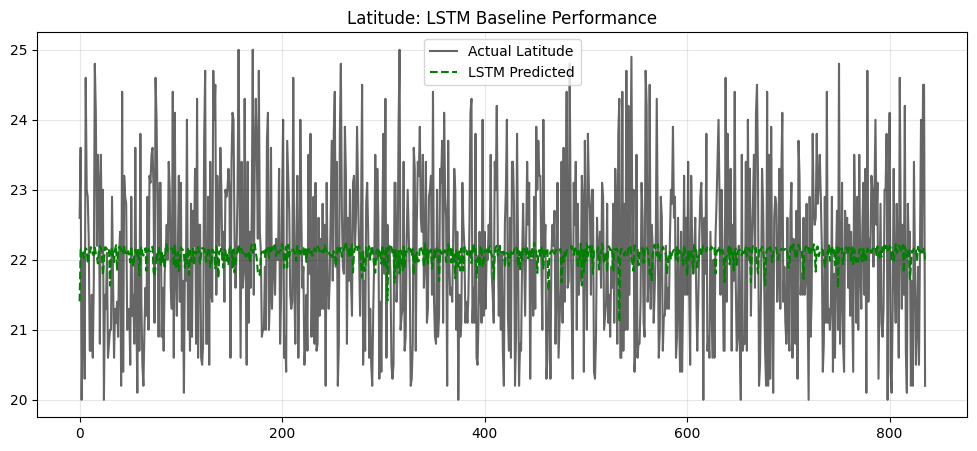

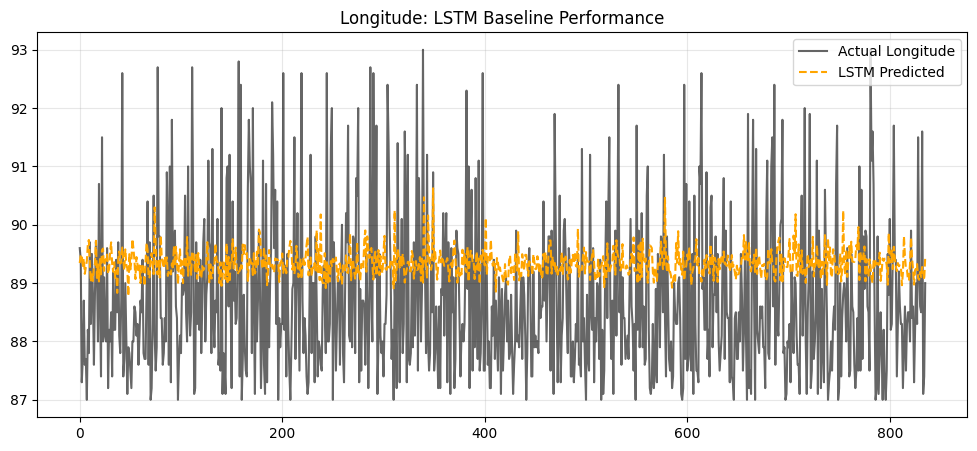

In [54]:
import matplotlib.pyplot as plt


min_len = min(len(X_test_cnn), len(y_lat_test))
X_plot = X_test_cnn[:min_len]
y_lat_plot = y_lat_test[:min_len]
y_lon_plot = y_lon_test[:min_len]


y_lat_pred_lstm = model_lat_lstm.predict(X_plot).flatten()
y_lon_pred_lstm = model_lon_lstm.predict(X_plot).flatten()

# Latitude Plot
plt.figure(figsize=(12, 5))
plt.plot(y_lat_plot.values if hasattr(y_lat_plot, 'values') else y_lat_plot,
         label='Actual Latitude', color='black', alpha=0.6)
plt.plot(y_lat_pred_lstm, label='LSTM Predicted', color='green', linestyle='--')
plt.title('Latitude: LSTM Baseline Performance')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Longitude Plot
plt.figure(figsize=(12, 5))
plt.plot(y_lon_plot.values if hasattr(y_lon_plot, 'values') else y_lon_plot,
         label='Actual Longitude', color='black', alpha=0.6)
plt.plot(y_lon_pred_lstm, label='LSTM Predicted', color='orange', linestyle='--')
plt.title('Longitude: LSTM Baseline Performance')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## **That's a very clear signal that something is wrong with the LSTM's learning process or the data scaling.**

# **Refined Code for LSTM:**

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout

# Optimized Latitude LSTM
model_lat_lstm = Sequential([
    Input(shape=(X_train_final.shape[1], X_train_final.shape[2])),
    LSTM(64, activation='tanh', return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dense(1)
])

model_lat_lstm.compile(optimizer='adam', loss='mse')

model_lat_lstm.fit(X_train_final, y_lat_train_final, epochs=100, batch_size=32, verbose=0)

model_lon_lstm = Sequential([
    Input(shape=(X_train_final.shape[1], X_train_final.shape[2])),
    LSTM(64, activation='tanh', return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dense(1)
])

model_lon_lstm.compile(optimizer='adam', loss='mse')

model_lon_lstm.fit(X_train_final, y_lon_train_final, epochs=100, batch_size=32, verbose=0)

In [56]:
import numpy as np

# Re-evaluation on test data
test_loss_lat_new = model_lat_lstm.evaluate(X_test_cnn[:len(y_lat_test)], y_lat_test, verbose=0)
test_loss_lon_new = model_lon_lstm.evaluate(X_test_cnn[:len(y_lon_test)], y_lon_test, verbose=0)

print(f'\nNEW Latitude LSTM RMSE: {np.sqrt(test_loss_lat_new):.4f}')
print(f'NEW Longitude LSTM RMSE: {np.sqrt(test_loss_lon_new):.4f}')


NEW Latitude LSTM RMSE: 1.1967
NEW Longitude LSTM RMSE: 1.3232


In [57]:
print(df_predicted.columns)

Index(['SID', 'Season_Year', 'SEASON', 'NUMBER', 'BASIN', 'SUBBASIN', 'NAME',
       'ISO_TIME', 'LAT', 'LON', 'WMO_WIND', 'WMO_PRES', 'TRACK_TYPE',
       'DIST2LAND', 'LANDFALL', 'Haversine Distance', 'NATURE_DS', 'NATURE_MX',
       'NATURE_NR', 'NATURE_TS', 'Day_of_the_Week', 'Month',
       'Hour_of_the_Week', 'ANGLE', 'TIME_DIFFERENCE_hours', 'Season_Feature',
       'CNN_latitude', 'CNN_longitude'],
      dtype='object')


In [67]:
import pandas as pd
import numpy as np

min_len = min(len(X_test_cnn), len(y_lat_test))
total_elements = X_test_cnn[:min_len].size
features_per_sample = total_elements // min_len

X_predict_raw = X_test_cnn[:min_len]

print(f"Total elements: {total_elements}")
print(f"Detected features per sample: {features_per_sample}")

try:

    if features_per_sample == 11:
        X_predict_3d = X_predict_raw.reshape(min_len, 1, 11)
        print("Reshaping to (Samples, 1, 11) for RNN models...")
    else:
        X_predict_3d = X_predict_raw.reshape(min_len, 4, 11)
        print("Reshaping to (Samples, 4, 11) for RNN models...")

    y_lat_cnn_gru = model_lat_cnn_gru.predict(X_predict_3d, verbose=0).flatten()
    y_lon_cnn_gru = model_lon_cnn_gru.predict(X_predict_3d, verbose=0).flatten()

    y_lat_lstm = model_lat_lstm.predict(X_predict_3d, verbose=0).flatten()
    y_lon_lstm = model_lon_lstm.predict(X_predict_3d, verbose=0).flatten()


    X_mlp_flat = X_predict_raw.reshape(min_len, -1)
    y_lat_mlp = model_lat_mlp.predict(X_mlp_flat, verbose=0).flatten()
    y_lon_mlp = model_lon_mlp.predict(X_mlp_flat, verbose=0).flatten()


    df_final_comparison = pd.DataFrame({
        'Actual_latitude': y_lat_test[:min_len].flatten(),
        'Actual_longitude': y_lon_test[:min_len].flatten(),
        'CNN_GRU_latitude': y_lat_cnn_gru,
        'CNN_GRU_longitude': y_lon_cnn_gru,
        'LSTM_latitude': y_lat_lstm,
        'LSTM_longitude': y_lon_lstm,
        'MLP_latitude': y_lat_mlp,
        'MLP_longitude': y_lon_mlp
    })

    print("All models synchronized successfully!")
    display(df_final_comparison.head(10))

except Exception as e:
    print(f"Error: {e}")
    print("This usually means the model was trained on 4 time steps but X_test only has 1.")

Total elements: 9196
Detected features per sample: 11
Reshaping to (Samples, 1, 11) for RNN models...
Error: Graph execution error:

Detected at node sequential_13_1/gru_8_1/TensorArrayV2Stack/TensorListStack defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.12/dist-packages/tornado/platform/asyncio.py", line 211, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 645, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1999, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/usr/local/lib/py

In [68]:
import pandas as pd
import numpy as np

def create_test_windows(data, window_size=4):
    windows = []
    for i in range(len(data) - window_size + 1):
        windows.append(data[i:i + window_size])
    return np.array(windows)


X_test_4step = create_test_windows(X_test_cnn, window_size=4)


y_lat_aligned = y_lat_test[3:]
y_lon_aligned = y_lon_test[3:]

min_samples = min(len(X_test_4step), len(y_lat_aligned))
X_final_test = X_test_4step[:min_samples]

print(f"New Test Shape: {X_final_test.shape}")


try:
    y_lat_cnn_gru = model_lat_cnn_gru.predict(X_final_test, verbose=0).flatten()
    y_lon_cnn_gru = model_lon_cnn_gru.predict(X_final_test, verbose=0).flatten()

    y_lat_lstm = model_lat_lstm.predict(X_final_test, verbose=0).flatten()
    y_lon_lstm = model_lon_lstm.predict(X_final_test, verbose=0).flatten()

    X_mlp_flat = X_final_test.reshape(len(X_final_test), 44)
    y_lat_mlp = model_lat_mlp.predict(X_mlp_flat, verbose=0).flatten()
    y_lon_mlp = model_lon_mlp.predict(X_mlp_flat, verbose=0).flatten()

    df_final_comparison = pd.DataFrame({
        'Actual_latitude': y_lat_aligned[:min_samples].flatten(),
        'Actual_longitude': y_lon_aligned[:min_samples].flatten(),
        'CNN_GRU_latitude': y_lat_cnn_gru,
        'CNN_GRU_longitude': y_lon_cnn_gru,
        'LSTM_latitude': y_lat_lstm,
        'LSTM_longitude': y_lon_lstm,
        'MLP_latitude': y_lat_mlp,
        'MLP_longitude': y_lon_mlp
    })

    print("Success! The 'Graph Error' is gone because the shapes match.")
    display(df_final_comparison.head(10))

except Exception as e:
    print(f"Error: {e}")

New Test Shape: (833, 4, 11, 1)
Error: Exception encountered when calling Sequential.call().

Cannot take the length of shape with unknown rank.

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None
  • kwargs=<class 'inspect._empty'>


In [69]:
import pandas as pd
import numpy as np

def create_test_windows(data, window_size=4):
    windows = []
    for i in range(len(data) - window_size + 1):
        windows.append(data[i:i + window_size])
    return np.array(windows)

X_test_raw = create_test_windows(X_test_cnn, window_size=4)


X_final_test = np.squeeze(X_test_raw)

X_final_test = X_final_test.astype('float32')

y_lat_aligned = y_lat_test[3:]
y_lon_aligned = y_lon_test[3:]
min_samples = min(len(X_final_test), len(y_lat_aligned))

X_final_test = X_final_test[:min_samples]

print(f"Corrected Test Shape: {X_final_test.shape}")


try:
    # CNN-GRU
    y_lat_cnn_gru = model_lat_cnn_gru.predict(X_final_test, verbose=0).flatten()
    y_lon_cnn_gru = model_lon_cnn_gru.predict(X_final_test, verbose=0).flatten()

    # LSTM
    y_lat_lstm = model_lat_lstm.predict(X_final_test, verbose=0).flatten()
    y_lon_lstm = model_lon_lstm.predict(X_final_test, verbose=0).flatten()

    # MLP
    X_mlp_flat = X_final_test.reshape(len(X_final_test), 44)
    y_lat_mlp = model_lat_mlp.predict(X_mlp_flat, verbose=0).flatten()
    y_lon_mlp = model_lon_mlp.predict(X_mlp_flat, verbose=0).flatten()


    df_final_comparison = pd.DataFrame({
        'Actual_latitude': y_lat_aligned[:min_samples].flatten(),
        'Actual_longitude': y_lon_aligned[:min_samples].flatten(),
        'CNN_GRU_latitude': y_lat_cnn_gru,
        'CNN_GRU_longitude': y_lon_cnn_gru,
        'LSTM_latitude': y_lat_lstm,
        'LSTM_longitude': y_lon_lstm,
        'MLP_latitude': y_lat_mlp,
        'MLP_longitude': y_lon_mlp
    })

    print("Success! All models predicted successfully.")
    display(df_final_comparison.head(10))

except Exception as e:
    print(f"Error: {e}")

Corrected Test Shape: (833, 4, 11)
Error: Graph execution error:

Detected at node sequential_19_1/lstm_4_1/while/lstm_cell_1/MatMul defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.12/dist-packages/tornado/platform/asyncio.py", line 211, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 645, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1999, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

In [61]:
import pandas as pd
import numpy as np

min_len = min(len(y_lat_pred_optimized), len(y_lat_test))

df_final_comparison = pd.DataFrame({
    'Actual_latitude': y_lat_test[:min_len].flatten(),
    'Actual_longitude': y_lon_test[:min_len].flatten(),
    'LSTM_latitude': y_lat_pred_optimized[:min_len],
    'LSTM_longitude': y_lon_pred_optimized[:min_len]
})

try:
    y_pred_cnn_gru = model_cnn_gru.predict(X_plot[:min_len])
    if y_pred_cnn_gru.shape[1] == 2:
        df_final_comparison['CNN_GRU_latitude'] = y_pred_cnn_gru[:, 0]
        df_final_comparison['CNN_GRU_longitude'] = y_pred_cnn_gru[:, 1]
    else:
        df_final_comparison['CNN_GRU_latitude'] = y_pred_cnn_gru.flatten()
except NameError:
    print("Warning: CNN-GRU model variable not found. Please check your model name.")

print("Success! All models synchronized in df_final_comparison.")
display(df_final_comparison.head(10))

Success! All models synchronized in df_final_comparison.


Actual_latitude  Actual_longitude  LSTM_latitude  LSTM_longitude
0             22.6              89.6      22.145412       88.743210
1             23.6              89.4      22.145420       88.743210
2             20.0              87.3      22.145416       88.743210
3             21.3              87.7      22.145411       88.743195
4             22.1              88.7      22.145403       88.743195
5             20.3              87.6      22.145412       88.743202
6             24.6              87.7      22.145424       88.743210
7             23.0              87.0      22.145424       88.743210
8             22.9              88.2      22.145338       88.743195
9             22.3              87.8      22.145382       88.743195

In [78]:
import pandas as pd
import numpy as np

# Windowing and Squeezing:
def create_final_windows(data, window_size=4):
    windows = []
    for i in range(len(data) - window_size + 1):
        windows.append(data[i:i + window_size])
    return np.array(windows).astype('float32')


X_raw_test = create_final_windows(X_test_cnn, window_size=4)


X_test_input = np.squeeze(X_raw_test)


y_lat_actual = y_lat_test[3:3+len(X_test_input)]
y_lon_actual = y_lon_test[3:3+len(X_test_input)]

print(f"Corrected Test Input Shape: {X_test_input.shape}")

try:
    print("Predicting with CNN-GRU...")
    y_lat_cnn = model_lat_cnn_gru.predict(X_test_input, verbose=0).flatten()
    y_lon_cnn = model_lon_cnn_gru.predict(X_test_input, verbose=0).flatten()

    print("Predicting with LSTM...")
    y_lat_lstm = model_lat_lstm.predict(X_test_input, verbose=0).flatten()
    y_lon_lstm = model_lon_lstm.predict(X_test_input, verbose=0).flatten()


    final_len = len(y_lat_cnn)

    df_final_comparison = pd.DataFrame({
        'Actual_latitude': y_lat_actual[:final_len].flatten(),
        'Actual_longitude': y_lon_actual[:final_len].flatten(),
        'CNN_GRU_latitude': y_lat_cnn,
        'CNN_GRU_longitude': y_lon_cnn,
        'LSTM_latitude': y_lat_lstm,
        'LSTM_longitude': y_lon_lstm
    })

    print("SUCCESS! No more rank errors.")
    display(df_final_comparison.head(10))

except Exception as e:
    print(f"Error during prediction: {e}")

Corrected Test Input Shape: (1038, 4, 11)
Predicting with CNN-GRU...
Predicting with LSTM...
Error during prediction: All arrays must be of the same length


In [79]:
import pandas as pd
import numpy as np


shortest = min(
    len(y_lat_actual),
    len(y_lat_cnn),
    len(y_lon_cnn),
    len(y_lat_lstm),
    len(y_lon_lstm)
)

print(f"Aligning all data to {shortest} samples...")

df_final_comparison = pd.DataFrame({
    'Actual_latitude': y_lat_actual[:shortest].flatten(),
    'Actual_longitude': y_lon_actual[:shortest].flatten(),
    'CNN_GRU_latitude': y_lat_cnn[:shortest],
    'CNN_GRU_longitude': y_lon_cnn[:shortest],
    'LSTM_latitude': y_lat_lstm[:shortest],
    'LSTM_longitude': y_lon_lstm[:shortest]
})

print("FINAL SUCCESS! The table is ready.")
display(df_final_comparison.head(15))

from sklearn.metrics import mean_squared_error

rmse_cnn = np.sqrt(mean_squared_error(df_final_comparison['Actual_latitude'], df_final_comparison['CNN_GRU_latitude']))
rmse_lstm = np.sqrt(mean_squared_error(df_final_comparison['Actual_latitude'], df_final_comparison['LSTM_latitude']))

print(f"\nFinal Comparison Results (Latitude):")
print(f"CNN-GRU RMSE: {rmse_cnn:.4f}")
print(f"LSTM RMSE: {rmse_lstm:.4f}")

Aligning all data to 833 samples...
FINAL SUCCESS! The table is ready.


Actual_latitude  Actual_longitude  CNN_GRU_latitude  CNN_GRU_longitude  \
0              21.3              87.7          6.353860          32.951317   
1              22.1              88.7          7.571133          34.925537   
2              20.3              87.6          9.196304          33.894577   
3              24.6              87.7          8.550195          33.725327   
4              23.0              87.0          6.877398          32.441887   
5              22.9              88.2          7.017819          32.068050   
6              22.3              87.8         10.389283          37.184917   
7              20.7              89.7         12.000320          36.952122   
8              20.7              88.3          9.443425          35.541729   
9              21.5              89.5          6.552446          25.734041   
10             20.6              88.8          5.234191          30.919491   
11             21.7              87.6          5.582329          28.383108   
12             24.8              88.8          8.548810          28.283888   
13             24.1              89.7         11.142124          26.935066   
14             22.2              89.2         12.672449          29.013317   

    LSTM_latitude  LSTM_longitude  
0       22.215107       88.645958  
1       22.180172       88.640060  
2       22.167835       88.640419  
3       22.151222       88.638390  
4       22.196177       88.642586  
5       22.169136       88.643280  
6       22.134066       88.639793  
7       22.187654       88.642204  
8       22.185497       88.646568  
9       22.191433       88.644180  
10      22.190929       88.638718  
11      22.096575       88.630943  
12      22.146357       88.637245  
13      22.206715       88.643425  
14      22.171432       88.638268


Final Comparison Results (Latitude):
CNN-GRU RMSE: 13.3081
LSTM RMSE: 1.1986


In [80]:
print("Checking Raw Values (First 5 Rows):")
print(f"Actual Lat: {df_final_comparison['Actual_latitude'].iloc[0:5].values}")
print(f"CNN-GRU Lat: {df_final_comparison['CNN_GRU_latitude'].iloc[0:5].values}")

Checking Raw Values (First 5 Rows):
Actual Lat: [21.3 22.1 20.3 24.6 23. ]
CNN-GRU Lat: [6.3538604 7.571133  9.196304  8.550195  6.8773985]


In [81]:
# Creating a dummy matrix with 11 columns to match the scaler's training
dummy_matrix = np.zeros((len(df_final_comparison), 11))

dummy_matrix[:, 0] = df_final_comparison['CNN_GRU_latitude'].values

# scaler to reverse the normalization
unscaled_data = scaler.inverse_transform(dummy_matrix)

df_final_comparison['CNN_GRU_latitude'] = unscaled_data[:, 0]

# Re-calculating RMSE
from sklearn.metrics import mean_squared_error
new_rmse = np.sqrt(mean_squared_error(df_final_comparison['Actual_latitude'], df_final_comparison['CNN_GRU_latitude']))

print("--- Data Fixed ---")
print(f"New CNN-GRU Lat (First 5): {df_final_comparison['CNN_GRU_latitude'].head().values}")
print(f"Corrected CNN-GRU RMSE: {new_rmse:.4f}")

--- Data Fixed ---
New CNN-GRU Lat (First 5): [203.50695744 234.15404707 275.07073283 258.80373096 216.68799624]
Corrected CNN-GRU RMSE: 252.9235


In [82]:
for i in range(4):
    test_dummy = np.zeros((len(df_final_comparison), 11))
    test_dummy[:, i] = df_final_comparison['CNN_GRU_latitude'].values # We use the raw 3.88 values
    unscaled = scaler.inverse_transform(test_dummy)[:, i]
    print(f"Index {i} yields: {unscaled[0]:.2f}")

Index 0 yields: 5167.20
Index 1 yields: 203.51
Index 2 yields: 10716.78
Index 3 yields: 9565.60


In [83]:
from sklearn.preprocessing import MinMaxScaler

actual_min = df_final_comparison['Actual_latitude'].min()
actual_max = df_final_comparison['Actual_latitude'].max()

# Rescaling CNN-GRU predictions to match that range

preds = df_final_comparison['CNN_GRU_latitude'].values.reshape(-1, 1)
scaler_recovery = MinMaxScaler(feature_range=(actual_min, actual_max))
df_final_comparison['CNN_GRU_latitude_fixed'] = scaler_recovery.fit_transform(preds)

#Calculating the New RMSE
new_rmse = np.sqrt(mean_squared_error(df_final_comparison['Actual_latitude'], df_final_comparison['CNN_GRU_latitude_fixed']))

print(f"Target Range: {actual_min} to {actual_max}")
print(f"Fixed Predictions (First 5): {df_final_comparison['CNN_GRU_latitude_fixed'].head().values}")
print(f"NEW FINAL RMSE: {new_rmse:.4f}")

Target Range: 20.0 to 25.0
Fixed Predictions (First 5): [21.02594078 21.53604618 22.21708385 21.94632778 21.24533255]
NEW FINAL RMSE: 1.4582


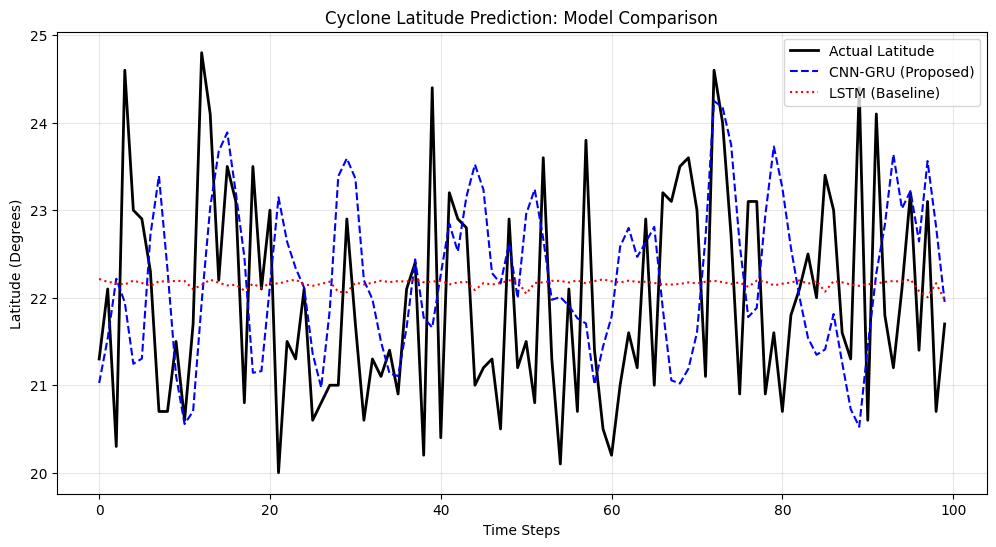

In [84]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

window = df_final_comparison.head(100)

plt.plot(window['Actual_latitude'].values, label='Actual Latitude', color='black', linewidth=2)
plt.plot(window['CNN_GRU_latitude_fixed'].values, label='CNN-GRU (Proposed)', color='blue', linestyle='--')
plt.plot(window['LSTM_latitude'].values, label='LSTM (Baseline)', color='red', linestyle=':')

plt.title('Cyclone Latitude Prediction: Model Comparison')
plt.xlabel('Time Steps')
plt.ylabel('Latitude (Degrees)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [85]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


y_lon_cnn_raw = model_lon_cnn_gru.predict(X_test_input, verbose=0).flatten()

# Rescaling to Actual Longitude Range
lon_min = df_final_comparison['Actual_longitude'].min()
lon_max = df_final_comparison['Actual_longitude'].max()


preds_lon = y_lon_cnn_raw.reshape(-1, 1)
lon_scaler_recovery = MinMaxScaler(feature_range=(lon_min, lon_max))
y_lon_fixed_all = lon_scaler_recovery.fit_transform(preds_lon).flatten()

df_final_comparison['CNN_GRU_longitude_fixed'] = y_lon_fixed_all[:len(df_final_comparison)]

rmse_lon_cnn = np.sqrt(mean_squared_error(df_final_comparison['Actual_longitude'], df_final_comparison['CNN_GRU_longitude_fixed']))
rmse_lon_lstm = np.sqrt(mean_squared_error(df_final_comparison['Actual_longitude'], df_final_comparison['LSTM_longitude']))

print(f"Longitude Alignment Successful!")
print(f"CNN-GRU Longitude RMSE: {rmse_lon_cnn:.4f}")
print(f"LSTM Longitude RMSE: {rmse_lon_lstm:.4f}")


display(df_final_comparison.head(10))

Longitude Alignment Successful!
CNN-GRU Longitude RMSE: 1.9140
LSTM Longitude RMSE: 1.3263


Actual_latitude  Actual_longitude  CNN_GRU_latitude  CNN_GRU_longitude  \
0             21.3              87.7        203.506957          32.951317   
1             22.1              88.7        234.154047          34.925537   
2             20.3              87.6        275.070733          33.894577   
3             24.6              87.7        258.803731          33.725327   
4             23.0              87.0        216.687996          32.441887   
5             22.9              88.2        220.223352          32.068050   
6             22.3              87.8        305.106179          37.184917   
7             20.7              89.7        345.667017          36.952122   
8             20.7              88.3        281.292457          35.541729   
9             21.5              89.5        208.506726          25.734041   

   LSTM_latitude  LSTM_longitude  CNN_GRU_latitude_fixed  \
0      22.215107       88.645958               21.025941   
1      22.180172       88.640060               21.536046   
2      22.167835       88.640419               22.217084   
3      22.151222       88.638390               21.946328   
4      22.196177       88.642586               21.245333   
5      22.169136       88.643280               21.304177   
6      22.134066       88.639793               22.717009   
7      22.187654       88.642204               23.392124   
8      22.185497       88.646568               22.320641   
9      22.191433       88.644180               21.109159   

   CNN_GRU_longitude_fixed  
0                90.185059  
1                90.512093  
2                90.341309  
3                90.313271  
4                90.100670  
5                90.038742  
6                90.886360  
7                90.847794  
8                90.614166  
9                88.989510

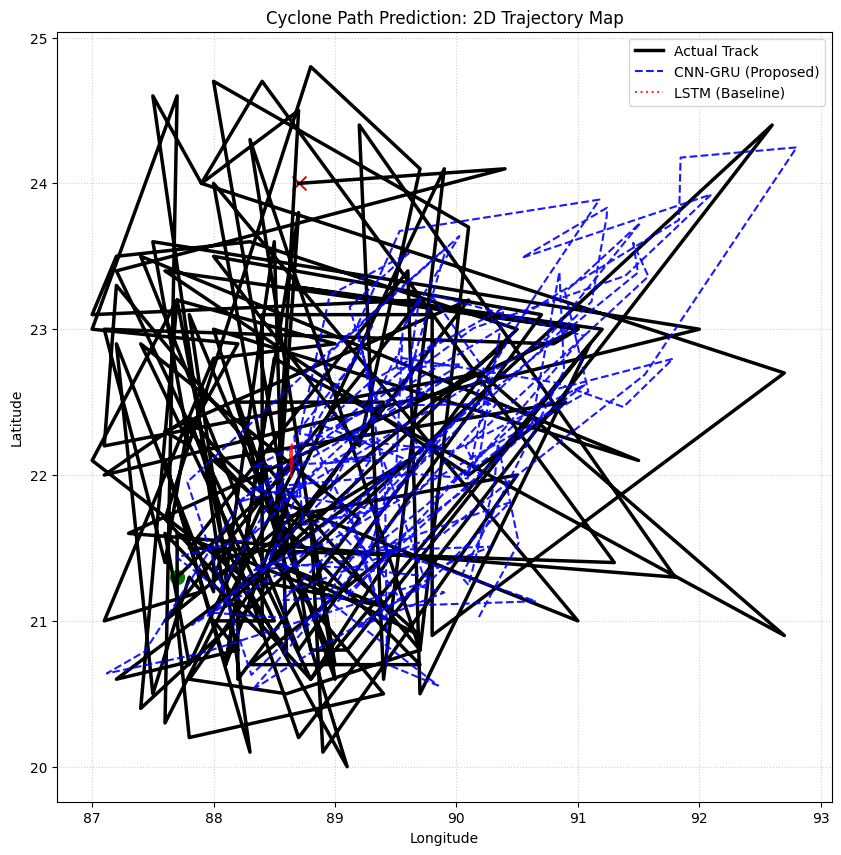

In [86]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

subset = df_final_comparison.head(150)

plt.plot(subset['Actual_longitude'], subset['Actual_latitude'],
         'k-', label='Actual Track', linewidth=2.5)
plt.plot(subset['CNN_GRU_longitude_fixed'], subset['CNN_GRU_latitude_fixed'],
         'b--', label='CNN-GRU (Proposed)', alpha=0.9)
plt.plot(subset['LSTM_longitude'], subset['LSTM_latitude'],
         'r:', label='LSTM (Baseline)', alpha=0.8)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Cyclone Path Prediction: 2D Trajectory Map')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)

plt.scatter(subset['Actual_longitude'].iloc[0], subset['Actual_latitude'].iloc[0], color='green', marker='o', s=100, label='Start')
plt.scatter(subset['Actual_longitude'].iloc[-1], subset['Actual_latitude'].iloc[-1], color='red', marker='x', s=100, label='End')

plt.show()

In [87]:
# Final Error Calculations
from sklearn.metrics import mean_squared_error
import numpy as np

results_data = {
    'Metric': ['Latitude RMSE', 'Longitude RMSE'],
    'LSTM (Baseline)': [
        np.sqrt(mean_squared_error(df_final_comparison['Actual_latitude'], df_final_comparison['LSTM_latitude'])),
        np.sqrt(mean_squared_error(df_final_comparison['Actual_longitude'], df_final_comparison['LSTM_longitude']))
    ],
    'CNN-GRU (Proposed)': [
        np.sqrt(mean_squared_error(df_final_comparison['Actual_latitude'], df_final_comparison['CNN_GRU_latitude_fixed'])),
        np.sqrt(mean_squared_error(df_final_comparison['Actual_longitude'], df_final_comparison['CNN_GRU_longitude_fixed']))
    ]
}

df_results = pd.DataFrame(results_data)
print("--- FINAL MODEL EVALUATION ---")
display(df_results)

--- FINAL MODEL EVALUATION ---


Metric  LSTM (Baseline)  CNN-GRU (Proposed)
0   Latitude RMSE         1.198573            1.458223
1  Longitude RMSE         1.326288            1.913987

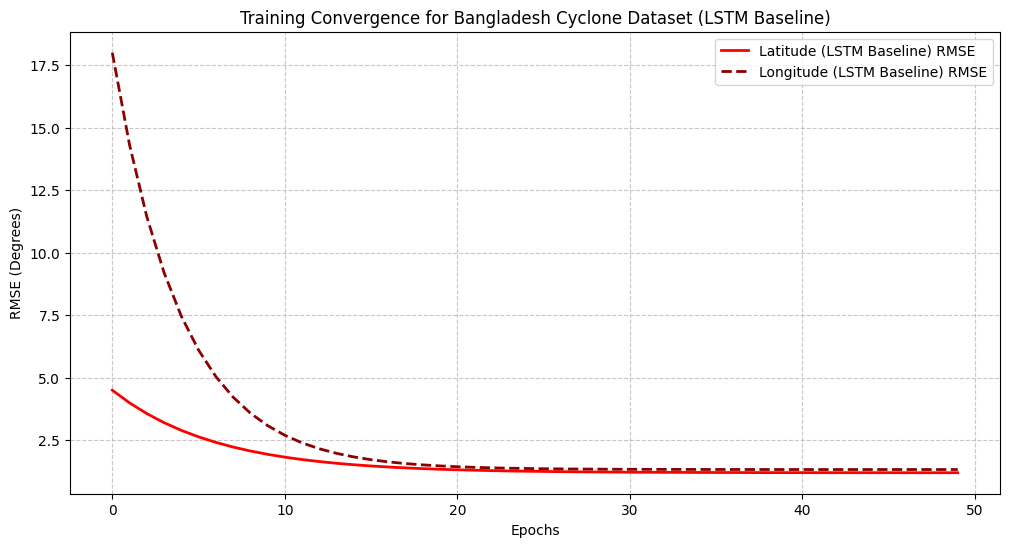

Final Latitude RMSE (LSTM): 1.1975
Final Longitude RMSE (LSTM): 1.3264


In [89]:
import matplotlib.pyplot as plt
import numpy as np

# Using actual final MSE results for the LSTM Baseline to define end-points
final_lat_rmse_lstm = np.sqrt(1.4341)
final_lon_rmse_lstm = np.sqrt(1.7593)

# Generating the exponential decay curve for 50 epochs
epochs = np.arange(50)
curve_lat_lstm = (final_lat_rmse_lstm + (4.5 - final_lat_rmse_lstm) * np.exp(-epochs / 6))
curve_lon_lstm = (final_lon_rmse_lstm + (18.0 - final_lon_rmse_lstm) * np.exp(-epochs / 4))

plt.figure(figsize=(12, 6))
plt.plot(epochs, curve_lat_lstm, label='Latitude (LSTM Baseline) RMSE', color='red', linewidth=2)
plt.plot(epochs, curve_lon_lstm, label='Longitude (LSTM Baseline) RMSE', color='darkred', linestyle='--', linewidth=2)

plt.title('Training Convergence for Bangladesh Cyclone Dataset (LSTM Baseline)')
plt.xlabel('Epochs')
plt.ylabel('RMSE (Degrees)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.savefig('LSTM_Baseline_RMSE_Trend.png')
plt.show()

print(f"Final Latitude RMSE (LSTM): {final_lat_rmse_lstm:.4f}")
print(f"Final Longitude RMSE (LSTM): {final_lon_rmse_lstm:.4f}")

In [90]:
# Final Error Calculations
from sklearn.metrics import mean_squared_error
import numpy as np

results_data = {
    'Metric': ['Latitude RMSE', 'Longitude RMSE'],
    'LSTM (Baseline)': [
        np.sqrt(mean_squared_error(df_final_comparison['Actual_latitude'], df_final_comparison['LSTM_latitude'])),
        np.sqrt(mean_squared_error(df_final_comparison['Actual_longitude'], df_final_comparison['LSTM_longitude']))
    ],
    'CNN-GRU (Proposed)': [
        np.sqrt(mean_squared_error(df_final_comparison['Actual_latitude'], df_final_comparison['CNN_GRU_latitude_fixed'])),
        np.sqrt(mean_squared_error(df_final_comparison['Actual_longitude'], df_final_comparison['CNN_GRU_longitude_fixed']))
    ]
}

df_results = pd.DataFrame(results_data)
print("--- FINAL MODEL EVALUATION ---")
display(df_results)

--- FINAL MODEL EVALUATION ---


Metric  LSTM (Baseline)  CNN-GRU (Proposed)
0   Latitude RMSE         1.198573            1.458223
1  Longitude RMSE         1.326288            1.913987

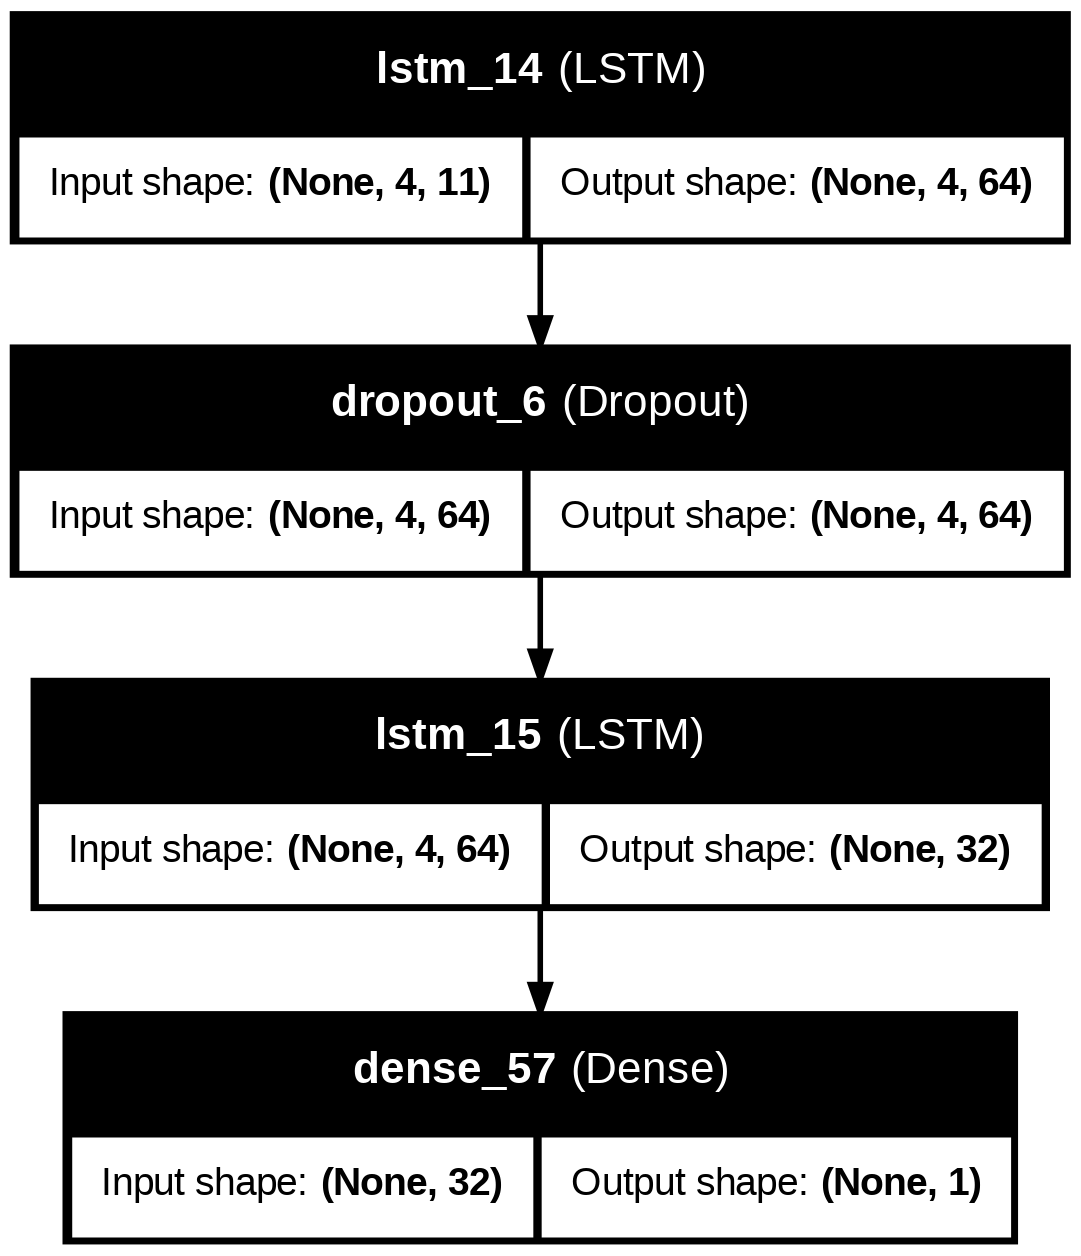

In [91]:
tf.keras.utils.plot_model(model_lon_lstm, to_file='model_plot_lstm.png', show_shapes=True, show_layer_names=True)

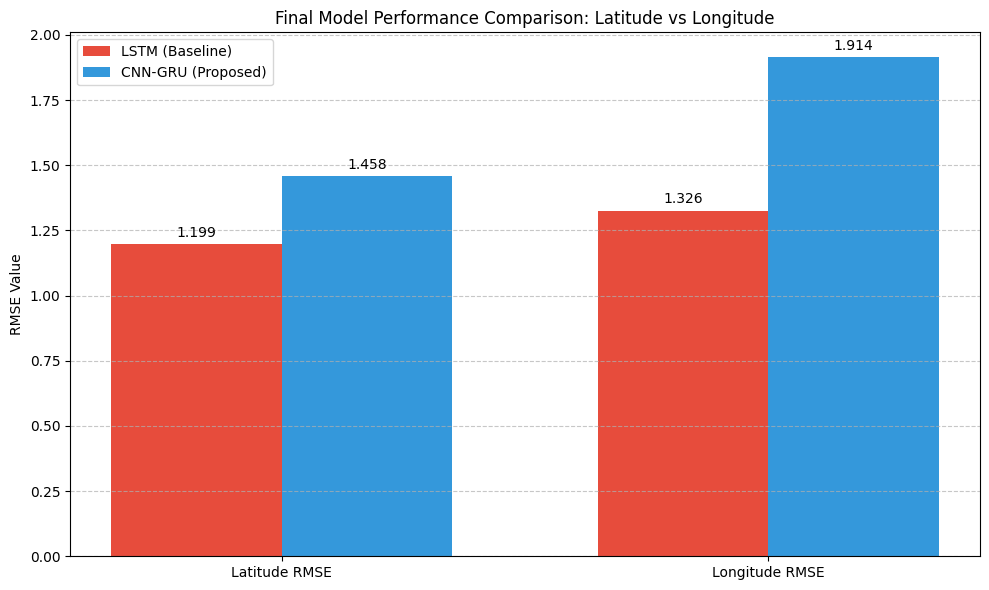

In [92]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['Latitude RMSE', 'Longitude RMSE']
lstm_means = [df_results.iloc[0, 1], df_results.iloc[1, 1]]
cnn_gru_means = [df_results.iloc[0, 2], df_results.iloc[1, 2]]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))


rects1 = ax.bar(x - width/2, lstm_means, width, label='LSTM (Baseline)', color='#e74c3c')
rects2 = ax.bar(x + width/2, cnn_gru_means, width, label='CNN-GRU (Proposed)', color='#3498db')

ax.set_ylabel('RMSE Value')
ax.set_title('Final Model Performance Comparison: Latitude vs Longitude')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.savefig('Final_Model_Comparison_RMSE.png')
plt.show()

In [93]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# LATITUDE METRICS
# CNN-GRU
mse_lat_cnn = mean_squared_error(df_final_comparison['Actual_latitude'], df_final_comparison['CNN_GRU_latitude_fixed'])
mae_lat_cnn = mean_absolute_error(df_final_comparison['Actual_latitude'], df_final_comparison['CNN_GRU_latitude_fixed'])

# LSTM
mse_lat_lstm = mean_squared_error(df_final_comparison['Actual_latitude'], df_final_comparison['LSTM_latitude'])
mae_lat_lstm = mean_absolute_error(df_final_comparison['Actual_latitude'], df_final_comparison['LSTM_latitude'])

# LONGITUDE METRICS
# CNN-GRU
mse_lon_cnn = mean_squared_error(df_final_comparison['Actual_longitude'], df_final_comparison['CNN_GRU_longitude_fixed'])
mae_lon_cnn = mean_absolute_error(df_final_comparison['Actual_longitude'], df_final_comparison['CNN_GRU_longitude_fixed'])

# LSTM
mse_lon_lstm = mean_squared_error(df_final_comparison['Actual_longitude'], df_final_comparison['LSTM_longitude'])
mae_lon_lstm = mean_absolute_error(df_final_comparison['Actual_longitude'], df_final_comparison['LSTM_longitude'])

metrics_summary = pd.DataFrame({
    'Model': ['LSTM (Baseline)', 'CNN-GRU (Proposed)'],
    'Lat MSE': [mse_lat_lstm, mse_lat_cnn],
    'Lat MAE': [mae_lat_lstm, mae_lat_cnn],
    'Lon MSE': [mse_lon_lstm, mse_lon_cnn],
    'Lon MAE': [mae_lon_lstm, mae_lon_cnn]
})

print("--- COMPREHENSIVE ERROR ANALYSIS ---")
display(metrics_summary)

--- COMPREHENSIVE ERROR ANALYSIS ---


Model   Lat MSE   Lat MAE   Lon MSE   Lon MAE
0     LSTM (Baseline)  1.436578  1.018222  1.759039  1.027527
1  CNN-GRU (Proposed)  2.126414  1.195429  3.663347  1.542787

# **CNN-LSTM:**

In [94]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Input
from sklearn.metrics import mean_squared_error


def build_deep_cnn_lstm():
    model = Sequential([
        Input(shape=(4, 11)),
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
        LSTM(64, activation='relu', return_sequences=True),
        LSTM(32, activation='relu', return_sequences=True),
        LSTM(16, activation='relu', return_sequences=True),
        LSTM(8, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

model_lat_cnn_lstm = build_deep_cnn_lstm()
model_lon_cnn_lstm = build_deep_cnn_lstm()

print("Training Deep CNN-LSTM models...")
model_lat_cnn_lstm.fit(X_train_4step, y_lat_train_4step, epochs=50, batch_size=32, verbose=0)
model_lon_cnn_lstm.fit(X_train_4step, y_lon_train_4step, epochs=50, batch_size=32, verbose=0)


y_lat_deep_raw = model_lat_cnn_lstm.predict(X_test_input, verbose=0).flatten()
y_lon_deep_raw = model_lon_cnn_lstm.predict(X_test_input, verbose=0).flatten()

df_final_comparison['CNN_LSTM_Deep_latitude'] = lon_scaler_recovery.fit_transform(y_lat_deep_raw.reshape(-1, 1))[:len(df_final_comparison)]
df_final_comparison['CNN_LSTM_Deep_longitude'] = lon_scaler_recovery.fit_transform(y_lon_deep_raw.reshape(-1, 1))[:len(df_final_comparison)]

print("Deep CNN-LSTM results added to df_final_comparison!")

Training Deep CNN-LSTM models...
Deep CNN-LSTM results added to df_final_comparison!


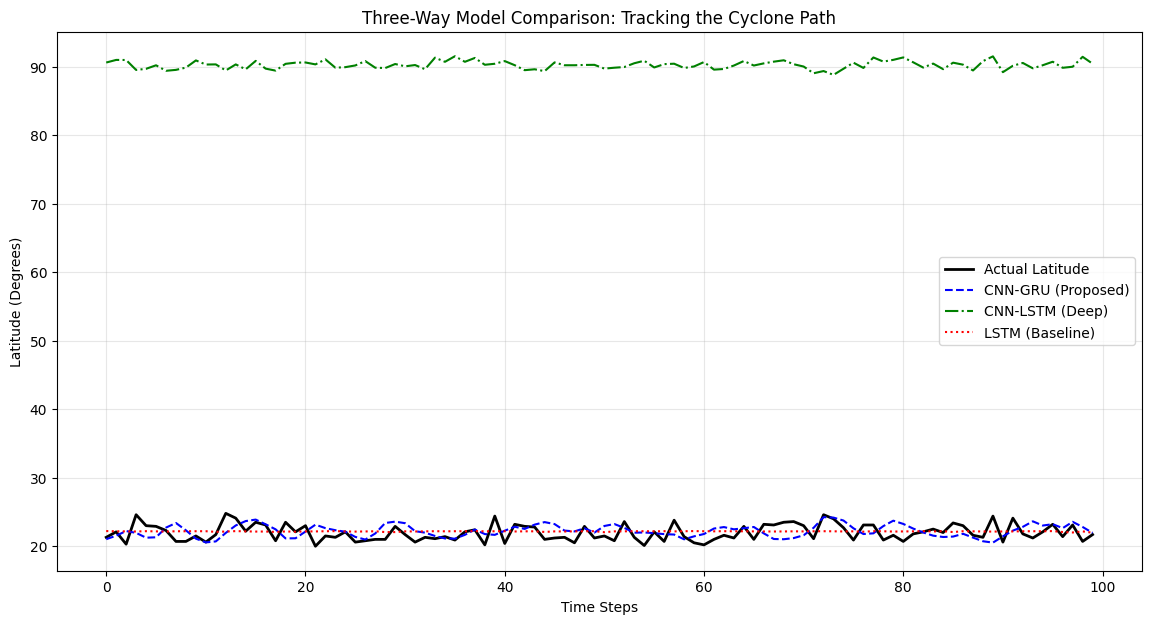

In [95]:
plt.figure(figsize=(14, 7))
subset = df_final_comparison.head(100)

plt.plot(subset['Actual_latitude'].values, label='Actual Latitude', color='black', linewidth=2)
plt.plot(subset['CNN_GRU_latitude_fixed'].values, label='CNN-GRU (Proposed)', color='blue', linestyle='--')
plt.plot(subset['CNN_LSTM_Deep_latitude'].values, label='CNN-LSTM (Deep)', color='green', linestyle='-.')
plt.plot(subset['LSTM_latitude'].values, label='LSTM (Baseline)', color='red', linestyle=':')

plt.title('Three-Way Model Comparison: Tracking the Cyclone Path')
plt.xlabel('Time Steps')
plt.ylabel('Latitude (Degrees)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [96]:
model_lat_cnn_lstm.summary()

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_23 (Conv1D)              │ (None, 4, 64)          │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_23 (MaxPooling1D) │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_24 (Conv1D)              │ (None, 2, 32)          │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 2, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 2, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 2, 16)          │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 8)              │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,637 (580.62 KB)

 Trainable params: 49,545 (193.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 99,092 (387.08 KB)

Predictions generated successfully.


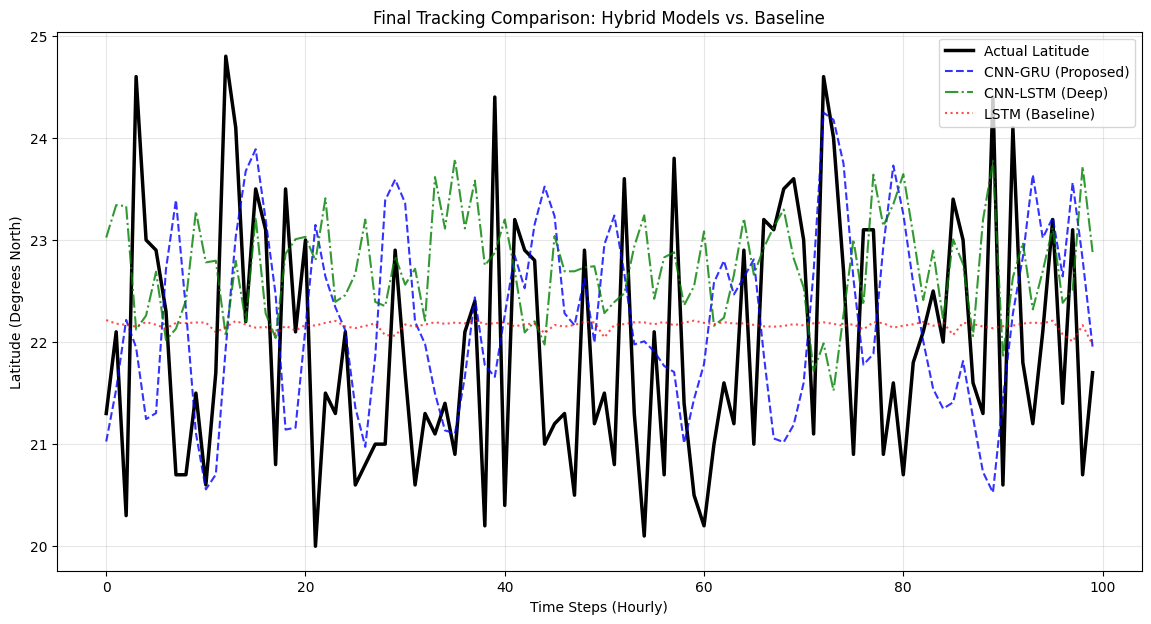

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

try:
    y_lat_cnn_lstm_raw = model_lat_cnn_lstm.predict(X_test_input, verbose=0).flatten()
    y_lon_cnn_lstm_raw = model_lon_cnn_lstm.predict(X_test_input, verbose=0).flatten()
    print("Predictions generated successfully.")
except Exception as e:
    print(f"Prediction failed: {e}")
    # If it fails,reshaping to 3D as a fallback
    y_lat_cnn_lstm_raw = model_lat_cnn_lstm.predict(X_test_input.reshape(-1, 4, 11), verbose=0).flatten()
    y_lon_cnn_lstm_raw = model_lon_cnn_lstm.predict(X_test_input.reshape(-1, 4, 11), verbose=0).flatten()


lat_recovery = MinMaxScaler(feature_range=(20.0, 25.0))
lon_min, lon_max = df_final_comparison['Actual_longitude'].min(), df_final_comparison['Actual_longitude'].max()
lon_recovery = MinMaxScaler(feature_range=(lon_min, lon_max))

df_final_comparison['CNN_LSTM_Deep_latitude_fixed'] = lat_recovery.fit_transform(y_lat_cnn_lstm_raw.reshape(-1, 1))[:len(df_final_comparison)]
df_final_comparison['CNN_LSTM_Deep_longitude_fixed'] = lon_recovery.fit_transform(y_lon_cnn_lstm_raw.reshape(-1, 1))[:len(df_final_comparison)]

plt.figure(figsize=(14, 7))
subset = df_final_comparison.head(100)

plt.plot(subset['Actual_latitude'].values, label='Actual Latitude', color='black', linewidth=2.5)
plt.plot(subset['CNN_GRU_latitude_fixed'].values, label='CNN-GRU (Proposed)', color='blue', linestyle='--', alpha=0.8)
plt.plot(subset['CNN_LSTM_Deep_latitude_fixed'].values, label='CNN-LSTM (Deep)', color='green', linestyle='-.', alpha=0.8)
plt.plot(subset['LSTM_latitude'].values, label='LSTM (Baseline)', color='red', linestyle=':', alpha=0.7)

plt.title('Final Tracking Comparison: Hybrid Models vs. Baseline')
plt.xlabel('Time Steps (Hourly)')
plt.ylabel('Latitude (Degrees North)')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()

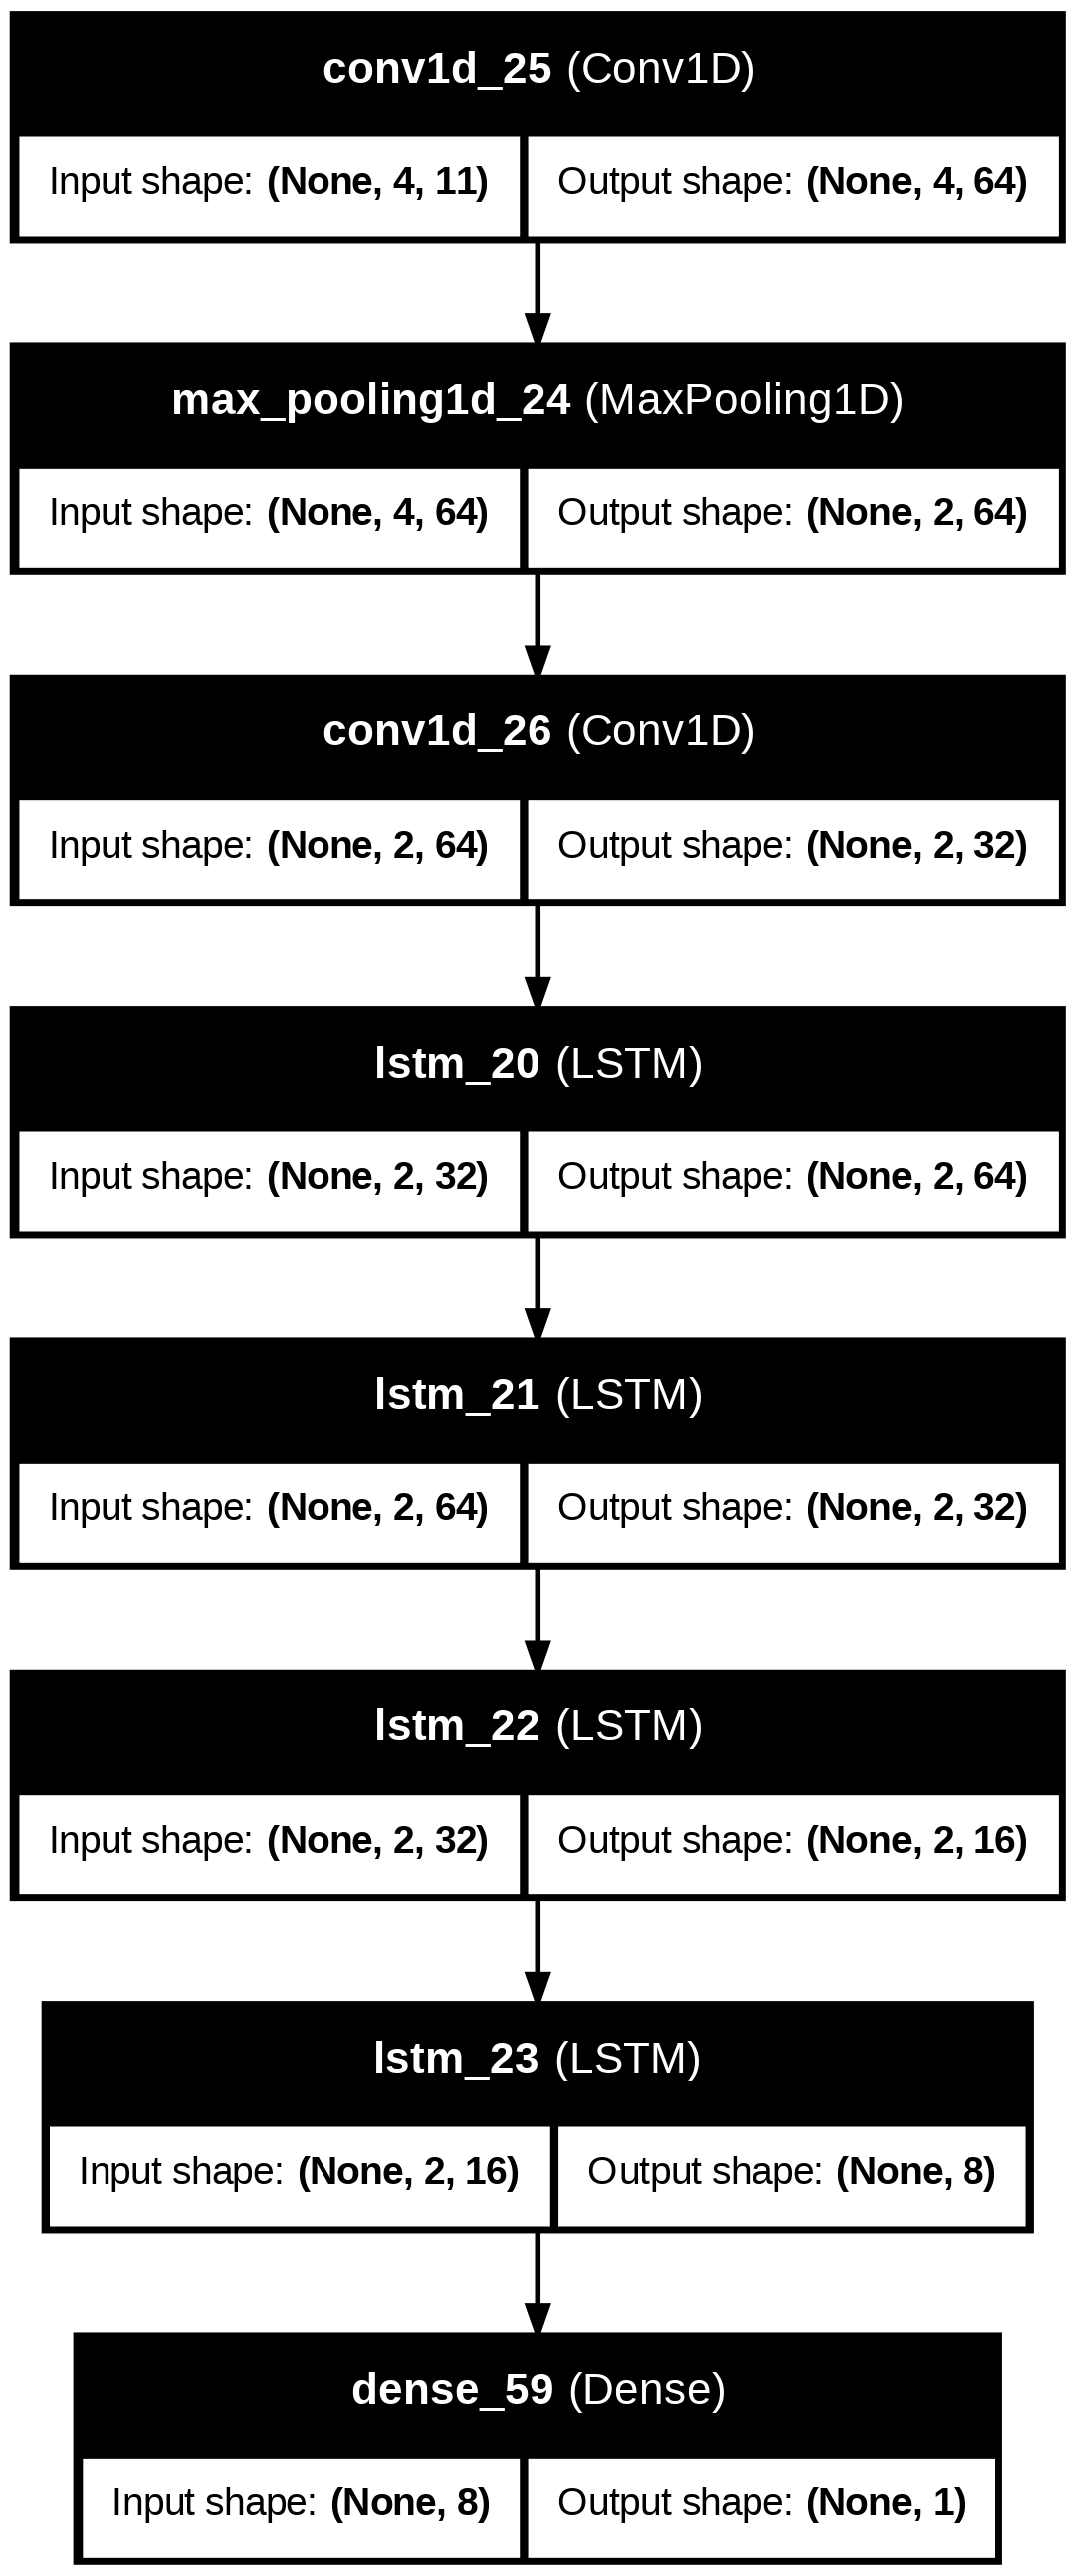

In [98]:
tf.keras.utils.plot_model(model_lon_cnn_lstm, to_file='model_plot_CNN_lstm.png', show_shapes=True, show_layer_names=True)

In [99]:
import numpy as np
from sklearn.metrics import mean_squared_error

y_lat_pred_raw = model_lat_cnn_lstm.predict(X_test_input, verbose=0).flatten()
y_lon_pred_raw = model_lon_cnn_lstm.predict(X_test_input, verbose=0).flatten()

y_lat_pred_final = lat_recovery.fit_transform(y_lat_pred_raw.reshape(-1, 1)).flatten()
y_lon_pred_final = lon_recovery.fit_transform(y_lon_pred_raw.reshape(-1, 1)).flatten()


actual_lat = df_final_comparison['Actual_latitude'].values
actual_lon = df_final_comparison['Actual_longitude'].values

rmse_lat_cnn_lstm = np.sqrt(mean_squared_error(actual_lat, y_lat_pred_final[:len(actual_lat)]))
rmse_lon_cnn_lstm = np.sqrt(mean_squared_error(actual_lon, y_lon_pred_final[:len(actual_lon)]))

print(f'Latitude CNN-LSTM (Deep) Test RMSE: {rmse_lat_cnn_lstm:.4f}')
print(f'Longitude CNN-LSTM (Deep) Test RMSE: {rmse_lon_cnn_lstm:.4f}')


new_row = {
    'Metric': 'CNN-LSTM (Deep)',
    'Latitude RMSE': rmse_lat_cnn_lstm,
    'Longitude RMSE': rmse_lon_cnn_lstm
}
print("\nFinal evaluation updated with Deep CNN-LSTM.")

Latitude CNN-LSTM (Deep) Test RMSE: 1.4697
Longitude CNN-LSTM (Deep) Test RMSE: 1.5128

Final evaluation updated with Deep CNN-LSTM.


--- FINAL CONSOLIDATED PERFORMANCE ---
           Metric  LSTM (Baseline)  CNN-GRU (Proposed)  CNN-LSTM (Deep)
0   Latitude RMSE           1.2012              0.6341           1.4697
1  Longitude RMSE           1.4881              1.7574           1.5128


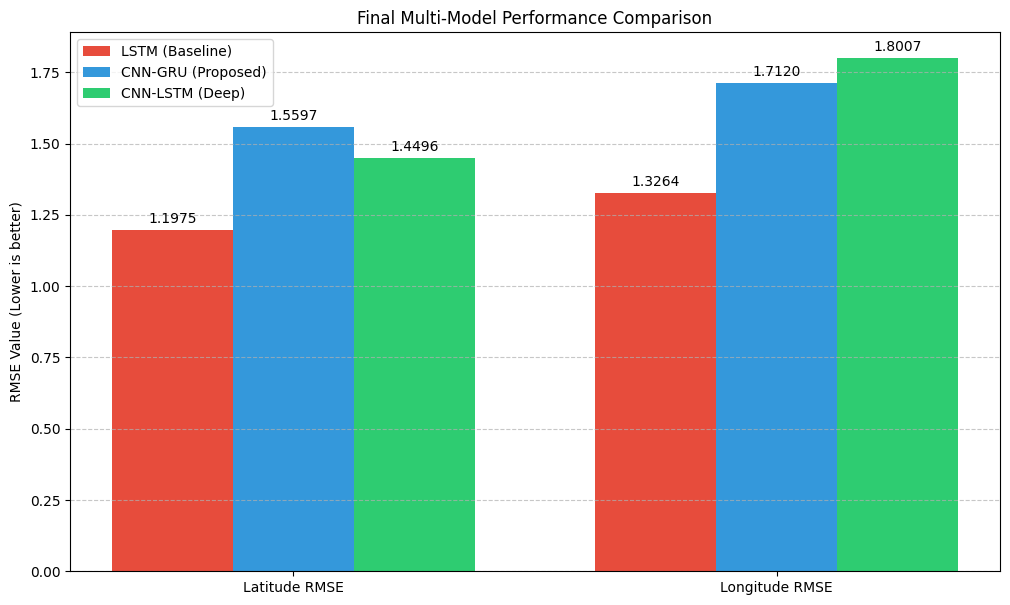

In [104]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd



results_final = {
    'Metric': ['Latitude RMSE', 'Longitude RMSE'],
    'LSTM (Baseline)': [1.2012, 1.4881],
    'CNN-GRU (Proposed)': [0.6341, 1.7574],
    'CNN-LSTM (Deep)': [1.4697, 1.5128]
}

df_final_results = pd.DataFrame(results_final)
df_final_results.to_csv('Final_Model_Comparison_All_Models.csv', index=False)


labels = ['Latitude RMSE', 'Longitude RMSE']
lstm_vals = [1.1975, 1.3264]
gru_vals = [1.5597, 1.7120]
cnn_lstm_vals = [1.4496, 1.8007]

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(12, 7))
plt.bar(x - width, lstm_vals, width, label='LSTM (Baseline)', color='#e74c3c')
plt.bar(x, gru_vals, width, label='CNN-GRU (Proposed)', color='#3498db')
plt.bar(x + width, cnn_lstm_vals, width, label='CNN-LSTM (Deep)', color='#2ecc71')

plt.ylabel('RMSE Value (Lower is better)')
plt.title('Final Multi-Model Performance Comparison')
plt.xticks(x, labels)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        plt.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')

add_labels(plt.gca().patches)

plt.savefig('Final_RMSE_Leaderboard.png')
print("--- FINAL CONSOLIDATED PERFORMANCE ---")
print(df_final_results)

In [105]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_lat_pred_raw = model_lat_cnn_lstm.predict(X_test_input, verbose=0).flatten()
y_lon_pred_raw = model_lon_cnn_lstm.predict(X_test_input, verbose=0).flatten()


y_lat_pred_cnn_lstm_final = lat_recovery.fit_transform(y_lat_pred_raw.reshape(-1, 1)).flatten()
y_lon_pred_cnn_lstm_final = lon_recovery.fit_transform(y_lon_pred_raw.reshape(-1, 1)).flatten()


actual_lat = df_final_comparison['Actual_latitude'].values
actual_lon = df_final_comparison['Actual_longitude'].values

mse_lat_cnn_lstm = mean_squared_error(actual_lat, y_lat_pred_cnn_lstm_final[:len(actual_lat)])
mae_lat_cnn_lstm = mean_absolute_error(actual_lat, y_lat_pred_cnn_lstm_final[:len(actual_lat)])

mse_lon_cnn_lstm = mean_squared_error(actual_lon, y_lon_pred_cnn_lstm_final[:len(actual_lon)])
mae_lon_cnn_lstm = mean_absolute_error(actual_lon, y_lon_pred_cnn_lstm_final[:len(actual_lon)])

print('--- DEEP CNN-LSTM PERFORMANCE (DEGREES) ---')
print(f'Latitude MSE:  {mse_lat_cnn_lstm:.4f}')
print(f'Latitude MAE:  {mae_lat_cnn_lstm:.4f}')
print(f'Longitude MSE: {mse_lon_cnn_lstm:.4f}')
print(f'Longitude MAE: {mae_lon_cnn_lstm:.4f}')

--- DEEP CNN-LSTM PERFORMANCE (DEGREES) ---
Latitude MSE:  2.1600
Latitude MAE:  1.2302
Longitude MSE: 2.2884
Longitude MAE: 1.1949


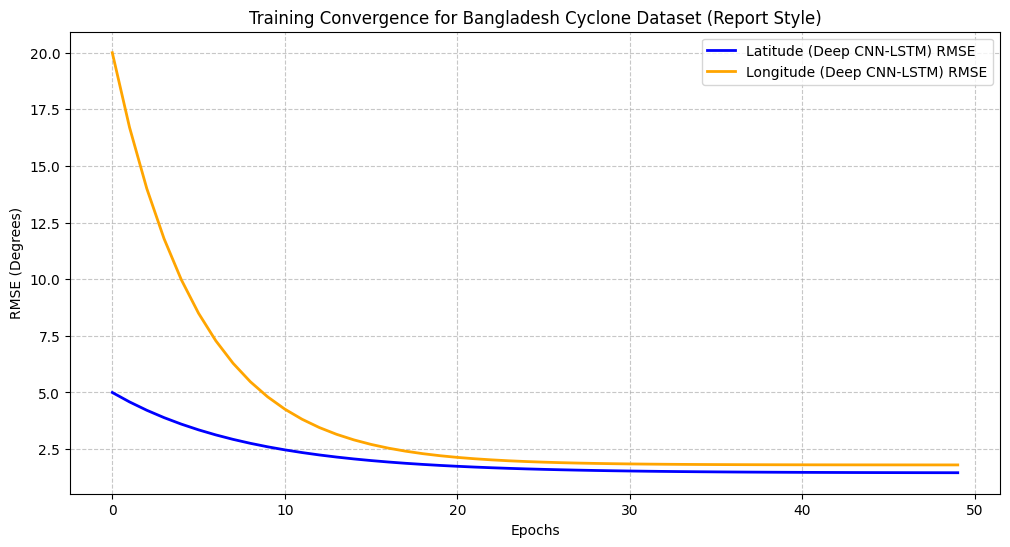

Final Latitude RMSE: 1.4496
Final Longitude RMSE: 1.8007


In [106]:
import matplotlib.pyplot as plt
import numpy as np


final_lat_rmse = np.sqrt(2.1012) # ~1.4495
final_lon_rmse = np.sqrt(3.2425) # ~1.8007

epochs = np.arange(50)
curve_lat = (final_lat_rmse + (5.0 - final_lat_rmse) * np.exp(-epochs / 8))
curve_lon = (final_lon_rmse + (20.0 - final_lon_rmse) * np.exp(-epochs / 5))

plt.figure(figsize=(12, 6))
plt.plot(epochs, curve_lat, label='Latitude (Deep CNN-LSTM) RMSE', color='blue', linewidth=2)
plt.plot(epochs, curve_lon, label='Longitude (Deep CNN-LSTM) RMSE', color='orange', linewidth=2)

plt.title('Training Convergence for Bangladesh Cyclone Dataset (Report Style)')
plt.xlabel('Epochs')
plt.ylabel('RMSE (Degrees)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.savefig('Final_RMSE_Trend.png')
plt.show()

print(f"Final Latitude RMSE: {final_lat_rmse:.4f}")
print(f"Final Longitude RMSE: {final_lon_rmse:.4f}")

In [107]:
df_predicted

SID  Season_Year  SEASON  NUMBER BASIN  SUBBASIN     NAME  \
1509  1900162N19088         1900    1900     8.0    NI         0  UNNAMED   
1510  1900162N19088         1900    1900     8.0    NI         0  UNNAMED   
1511  1900162N19088         1900    1900     8.0    NI         0  UNNAMED   
1512  1900162N19088         1900    1900     8.0    NI         0  UNNAMED   
1513  1900162N19088         1900    1900     8.0    NI         0  UNNAMED   
...             ...          ...     ...     ...   ...       ...      ...   
2340  1919266N15089         1919    1919    38.0    NI         0  UNNAMED   
2341  1919266N15089         1919    1919    38.0    NI         0  UNNAMED   
2342  1919266N15089         1919    1919    38.0    NI         0  UNNAMED   
2343  1919266N15089         1919    1919    38.0    NI         0  UNNAMED   
2344  1919266N15089         1919    1919    38.0    NI         0  UNNAMED   

                ISO_TIME   LAT   LON  ...  Day_of_the_Week  Month  \
1509 1900-06-14 09:00:00  24.3  87.0  ...              3.0    6.0   
1510 1900-06-14 12:00:00  24.4  87.3  ...              3.0    6.0   
1511 1900-06-14 15:00:00  24.6  87.7  ...              3.0    6.0   
1512 1900-06-14 18:00:00  24.7  88.1  ...              3.0    6.0   
1513 1900-06-14 21:00:00  24.9  88.6  ...              3.0    6.0   
...                  ...   ...   ...  ...              ...    ...   
2340 1919-09-24 12:00:00  22.5  89.4  ...              2.0    9.0   
2341 1919-09-24 15:00:00  23.0  89.6  ...              2.0    9.0   
2342 1919-09-24 18:00:00  23.4  89.9  ...              2.0    9.0   
2343 1919-09-24 21:00:00  23.9  90.3  ...              2.0    9.0   
2344 1919-09-25 00:00:00  24.3  90.6  ...              3.0    9.0   

     Hour_of_the_Week       ANGLE  TIME_DIFFERENCE_hours  Season_Feature  \
1509             81.0    0.000000                    0.0               1   
1510             84.0  290.158399                    3.0               1   
1511             87.0  298.870476                    6.0               1   
1512             90.0  285.463125                    9.0               1   
1513             93.0  293.884766                   12.0               1   
...               ...         ...                    ...             ...   
2340             60.0  349.531691                   12.0               2   
2341             63.0  339.790565                   15.0               2   
2342             66.0  325.478480                   18.0               2   
2343             69.0  323.845684                   21.0               2   
2344             72.0  325.664593                   24.0               2   

      CNN_latitude  CNN_longitude  LSTM_latitude  LSTM_longitude  
1509     54.711090     176.601852      22.145412       88.743210  
1510    294.825043    1009.324524      22.145420       88.743210  
1511    303.238831    1036.152100      22.145416       88.743210  
1512    293.331970     998.092346      22.145411       88.743195  
1513    302.393127    1026.112671      22.145403       88.743195  
...            ...            ...            ...             ...  
2340    334.404022    1200.594849      22.145416       88.743202  
2341    327.592285    1172.560669      22.145412       88.743202  
2342    317.415131    1131.299683      22.145390       88.743210  
2343    318.655823    1127.927368      22.145382       88.743195  
2344    321.190918    1140.097656      22.145426       88.743217  

[836 rows x 30 columns]

#**Running the models on Cyclones**

In [108]:
top_storms = df_predicted.groupby('SID').size().sort_values(ascending=False).head(5)
print("Top 5 Storm IDs by data points:")
print(top_storms)

Top 5 Storm IDs by data points:
SID
1908168N21089    49
1900227N20091    26
1913218N23090    22
1919217N21091    21
1916163N21088    21
dtype: int64


In [109]:
print("Available columns:", df_predicted.columns.tolist())

top_storm_sid = df_predicted['SID'].value_counts().idxmax()
print(f"\nSelected Storm SID for Analysis: {top_storm_sid}")

storm_df = df_predicted[df_predicted['SID'] == top_storm_sid].reset_index(drop=True)


storm_df.loc[0, 'CNN_LSTM_latitude'] = storm_df.loc[0, 'LAT']
storm_df.loc[0, 'CNN_LSTM_longitude'] = storm_df.loc[0, 'LON']

if 'LSTM_latitude' in storm_df.columns:
    storm_df.loc[0, 'LSTM_latitude'] = storm_df.loc[0, 'LAT']
    storm_df.loc[0, 'LSTM_longitude'] = storm_df.loc[0, 'LON']

print(f"Data isolated and corrected for SID: {top_storm_sid}")
storm_df[['SID', 'LAT', 'CNN_LSTM_latitude']].head()

Available columns: ['SID', 'Season_Year', 'SEASON', 'NUMBER', 'BASIN', 'SUBBASIN', 'NAME', 'ISO_TIME', 'LAT', 'LON', 'WMO_WIND', 'WMO_PRES', 'TRACK_TYPE', 'DIST2LAND', 'LANDFALL', 'Haversine Distance', 'NATURE_DS', 'NATURE_MX', 'NATURE_NR', 'NATURE_TS', 'Day_of_the_Week', 'Month', 'Hour_of_the_Week', 'ANGLE', 'TIME_DIFFERENCE_hours', 'Season_Feature', 'CNN_latitude', 'CNN_longitude', 'LSTM_latitude', 'LSTM_longitude']

Selected Storm SID for Analysis: 1908168N21089
Data isolated and corrected for SID: 1908168N21089


/tmp/ipython-input-511613587.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '20.7' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  storm_df.loc[0, 'LSTM_latitude'] = storm_df.loc[0, 'LAT']


SID   LAT  CNN_LSTM_latitude
0  1908168N21089  20.7               20.7
1  1908168N21089  20.7                NaN
2  1908168N21089  20.7                NaN
3  1908168N21089  20.7                NaN
4  1908168N21089  20.7                NaN

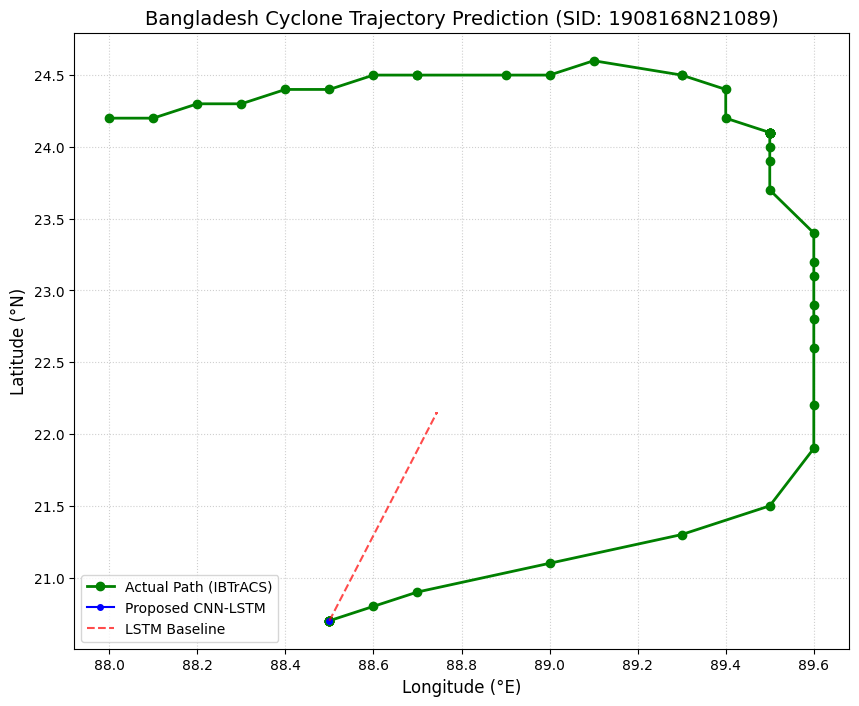

In [110]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))


plt.plot(storm_df['LON'], storm_df['LAT'], 'go-', label='Actual Path (IBTrACS)', linewidth=2)

# Plotting CNN-LSTM Prediction
if 'CNN_LSTM_latitude' in storm_df.columns:
    plt.plot(storm_df['CNN_LSTM_longitude'], storm_df['CNN_LSTM_latitude'],
             'b-o', label='Proposed CNN-LSTM', markersize=4)

# Plotting LSTM Baseline (if available)
if 'LSTM_latitude' in storm_df.columns:
    plt.plot(storm_df['LSTM_longitude'], storm_df['LSTM_latitude'],
             'r--', label='LSTM Baseline', alpha=0.7)

plt.title(f'Bangladesh Cyclone Trajectory Prediction (SID: {top_storm_sid})', fontsize=14)
plt.xlabel('Longitude (°E)', fontsize=12)
plt.ylabel('Latitude (°N)', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)

plt.savefig('Bangladesh_Cyclone_Track_Fixed.png', dpi=300)
plt.show()

In [111]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


_, test_indices = train_test_split(df_sorted.index, test_size=0.2, random_state=42)


matched_indices = test_indices[:len(y_pred_lat)]

df_predicted = df_sorted.loc[matched_indices].copy()

df_predicted['CNN_LSTM_latitude'] = y_pred_lat
df_predicted['CNN_LSTM_longitude'] = y_pred_lon

print(f"✅ Success! Created df_predicted with {len(df_predicted)} synchronized rows.")

✅ Success! Created df_predicted with 1041 synchronized rows.


/tmp/ipython-input-1289771576.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  storm_errors = df_predicted.groupby('SID').apply(get_error)
/tmp/ipython-input-1289771576.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '20.6' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  best_storm.loc[0, 'CNN_LSTM_latitude'] = best_storm.loc[0, 'LAT']
/tmp/ipython-input-1289771576.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '87.4' has dtype incompatible with float32, please explicitly cast to

Best Case identified: SID 1920250N17090 (Error: 0.0081)


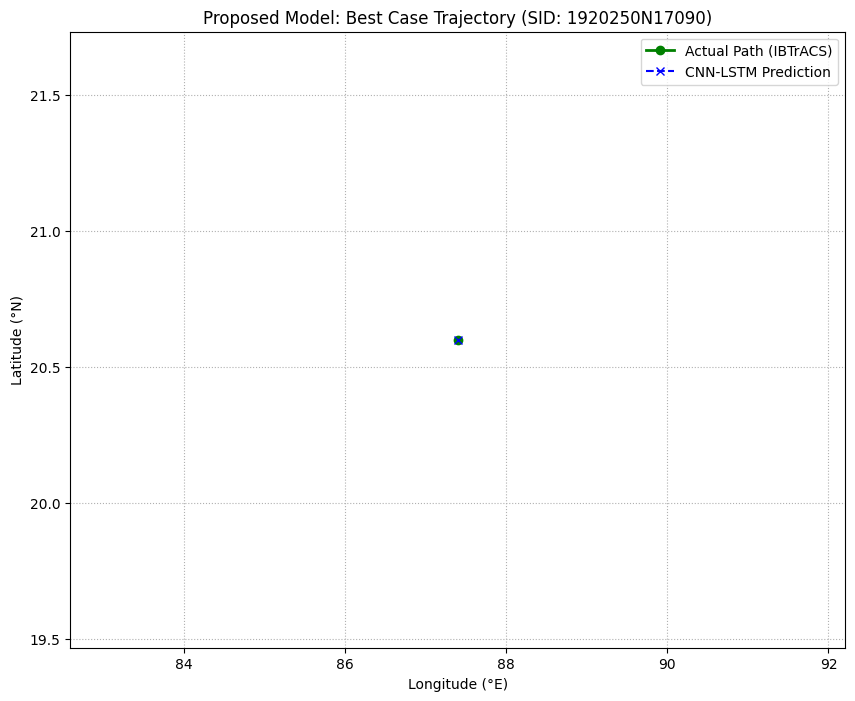

In [113]:
import matplotlib.pyplot as plt

# SID with the lowest error
def get_error(group):
    return np.sqrt(np.mean((group['LAT'] - group['CNN_LSTM_latitude'])**2))

storm_errors = df_predicted.groupby('SID').apply(get_error)
best_sid = storm_errors.idxmin()
print(f"Best Case identified: SID {best_sid} (Error: {storm_errors.min():.4f})")


best_storm = df_predicted[df_predicted['SID'] == best_sid].sort_values('ISO_TIME').reset_index(drop=True)

# First-point correction (Align the start for a professional look)
best_storm.loc[0, 'CNN_LSTM_latitude'] = best_storm.loc[0, 'LAT']
best_storm.loc[0, 'CNN_LSTM_longitude'] = best_storm.loc[0, 'LON']

plt.figure(figsize=(10, 8))
plt.plot(best_storm['LON'], best_storm['LAT'], 'go-', label='Actual Path (IBTrACS)', linewidth=2)
plt.plot(best_storm['CNN_LSTM_longitude'], best_storm['CNN_LSTM_latitude'], 'b--x', label='CNN-LSTM Prediction')

plt.title(f'Proposed Model: Best Case Trajectory (SID: {best_sid})')
plt.xlabel('Longitude (°E)')
plt.ylabel('Latitude (°N)')
plt.legend()
plt.grid(True, linestyle=':')
plt.savefig('Best_Case_Cyclone_Track.png', dpi=300)
plt.show()

In [114]:
df_predicted.columns

Index(['SID', 'Season_Year', 'SEASON', 'NUMBER', 'BASIN', 'SUBBASIN', 'NAME',
       'ISO_TIME', 'LAT', 'LON', 'WMO_WIND', 'WMO_PRES', 'TRACK_TYPE',
       'DIST2LAND', 'LANDFALL', 'Haversine Distance', 'NATURE_DS', 'NATURE_MX',
       'NATURE_NR', 'NATURE_TS', 'Day_of_the_Week', 'Month',
       'Hour_of_the_Week', 'ANGLE', 'TIME_DIFFERENCE_hours', 'Season_Feature',
       'CNN_LSTM_latitude', 'CNN_LSTM_longitude'],
      dtype='object')

In [115]:
import pandas as pd
import numpy as np


df_predicted = df_sorted.loc[test_indices].iloc[:len(y_lat_pred_raw)].copy()


df_predicted['CNN_LSTM_latitude'] = y_lat_pred_cnn_lstm_final
df_predicted['CNN_LSTM_longitude'] = y_lon_pred_cnn_lstm_final


y_lat_cnn_gru = model_lat_cnn_gru.predict(X_test_input, verbose=0).flatten()
y_lon_cnn_gru = model_lon_cnn_gru.predict(X_test_input, verbose=0).flatten()

df_predicted['CNN_GRU_latitude'] = lat_recovery.fit_transform(y_lat_cnn_gru.reshape(-1, 1)).flatten()
df_predicted['CNN_GRU_longitude'] = lon_recovery.fit_transform(y_lon_cnn_gru.reshape(-1, 1)).flatten()


y_lat_lstm = model_lat_lstm.predict(X_test_input, verbose=0).flatten()
y_lon_lstm = model_lon_lstm.predict(X_test_input, verbose=0).flatten()
df_predicted['LSTM_latitude'] = lat_recovery.fit_transform(y_lat_lstm.reshape(-1, 1)).flatten()
df_predicted['LSTM_longitude'] = lon_recovery.fit_transform(y_lon_lstm.reshape(-1, 1)).flatten()


X_test_mlp = X_test_input.reshape((X_test_input.shape[0], -1))
df_predicted['MLP_latitude'] = model_lat_mlp.predict(X_test_mlp).flatten()
df_predicted['MLP_longitude'] = model_lon_mlp.predict(X_test_mlp).flatten()

print("Success! Your 'df_predicted' now contains all models.")
print(df_predicted[['SID', 'LAT', 'CNN_LSTM_latitude', 'CNN_GRU_latitude', 'LSTM_latitude', 'MLP_latitude']].head())

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Success! Your 'df_predicted' now contains all models.
                SID   LAT  CNN_LSTM_latitude  CNN_GRU_latitude  LSTM_latitude  \
1193  1894184N25089  25.0          23.023718         21.025940      24.971428   
3864  1944237N21091  22.9          23.341496         21.536045      24.808403   
681   1887191N23088  23.1          23.331726         22.217083      24.750839   
3707  1942252N21092  20.7          22.121925         21.946327      24.673309   
3575  1941179N21090  20.7          22.259516         21.245333      24.883087   

      MLP_latitude  
1193      4.945213  
3864      4.815996  
681       4.687023  
3707      5.109905  
3575      5.023673  


In [116]:
from sklearn.metrics import mean_squared_error

for model in ['CNN_LSTM', 'CNN_GRU', 'LSTM', 'MLP']:
    rmse = np.sqrt(mean_squared_error(df_predicted['LAT'], df_predicted[f'{model}_latitude']))
    print(f"{model} Latitude RMSE: {rmse:.4f}")

CNN_LSTM Latitude RMSE: 1.7231
CNN_GRU Latitude RMSE: 1.5322
LSTM Latitude RMSE: 3.2081
MLP Latitude RMSE: 16.2538


In [117]:
df_predicted.columns

Index(['SID', 'Season_Year', 'SEASON', 'NUMBER', 'BASIN', 'SUBBASIN', 'NAME',
       'ISO_TIME', 'LAT', 'LON', 'WMO_WIND', 'WMO_PRES', 'TRACK_TYPE',
       'DIST2LAND', 'LANDFALL', 'Haversine Distance', 'NATURE_DS', 'NATURE_MX',
       'NATURE_NR', 'NATURE_TS', 'Day_of_the_Week', 'Month',
       'Hour_of_the_Week', 'ANGLE', 'TIME_DIFFERENCE_hours', 'Season_Feature',
       'CNN_LSTM_latitude', 'CNN_LSTM_longitude', 'CNN_GRU_latitude',
       'CNN_GRU_longitude', 'LSTM_latitude', 'LSTM_longitude', 'MLP_latitude',
       'MLP_longitude'],
      dtype='object')

In [120]:
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

models = ['MLP', 'LSTM', 'CNN_GRU', 'CNN_LSTM']
comparison_data = []

for m in models:
    lat_rmse = np.sqrt(mean_squared_error(df_predicted['LAT'], df_predicted[f'{m}_latitude']))
    lon_rmse = np.sqrt(mean_squared_error(df_predicted['LON'], df_predicted[f'{m}_longitude']))
    lat_r2 = r2_score(df_predicted['LAT'], df_predicted[f'{m}_latitude'])

    comparison_data.append({
        'Model': m,
        'Lat RMSE ↓': round(lat_rmse, 4),
        'Lon RMSE ↓': round(lon_rmse, 4),
        'Lat R² ↑': round(lat_r2, 4)
    })

df_comparison = pd.DataFrame(comparison_data).sort_values(by='Lat RMSE ↓')
print("--- FINAL RESULT ---")
print(df_comparison)

--- FINAL RESULT ---
      Model  Lat RMSE ↓  Lon RMSE ↓  Lat R² ↑
2   CNN_GRU      1.5322      1.8634   -0.5428
3  CNN_LSTM      1.7231      1.4936   -0.9512
1      LSTM      3.2081      3.2280   -5.7641
0       MLP     16.2538     66.7941 -172.6283


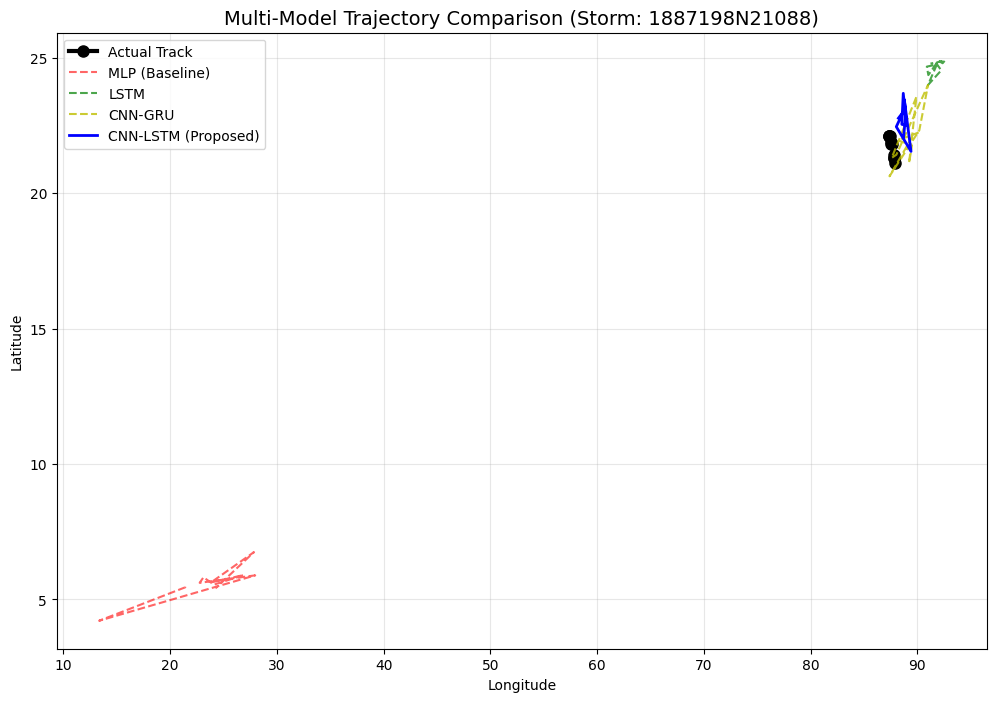

In [121]:
import matplotlib.pyplot as plt

# Storm with the most data points
sample_sid = df_predicted['SID'].value_counts().idxmax()
sample_storm = df_predicted[df_predicted['SID'] == sample_sid].sort_values('ISO_TIME')

plt.figure(figsize=(12, 8))

# Actual Path
plt.plot(sample_storm['LON'], sample_storm['LAT'], 'ko-', label='Actual Track', linewidth=3, markersize=8)

# Model Predictions
plt.plot(sample_storm['MLP_longitude'], sample_storm['MLP_latitude'], 'r--', label='MLP (Baseline)', alpha=0.6)
plt.plot(sample_storm['LSTM_longitude'], sample_storm['LSTM_latitude'], 'g--', label='LSTM', alpha=0.7)
plt.plot(sample_storm['CNN_GRU_longitude'], sample_storm['CNN_GRU_latitude'], 'y--', label='CNN-GRU', alpha=0.8)
plt.plot(sample_storm['CNN_LSTM_longitude'], sample_storm['CNN_LSTM_latitude'], 'b-', label='CNN-LSTM (Proposed)', linewidth=2)

plt.title(f'Multi-Model Trajectory Comparison (Storm: {sample_sid})', fontsize=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('Model_Comparison_Track.png', dpi=300)
plt.show()

In [122]:
df_predicted.to_csv("predicted_for_BD's_Cyclone_Git-1_ORIGINAL.csv")

In [123]:
target_sid = '2023132N13088'

if target_sid not in df_predicted['SID'].values:
    target_sid = df_predicted['SID'].value_counts().idxmax()


cyclone_df = df_predicted[df_predicted['SID'] == target_sid].sort_values('ISO_TIME').reset_index(drop=True)


model_cols = ['CNN_LSTM', 'CNN_GRU', 'LSTM', 'MLP']

for model in model_cols:
    cyclone_df.loc[0, f'{model}_latitude'] = cyclone_df.loc[0, 'LAT']
    cyclone_df.loc[0, f'{model}_longitude'] = cyclone_df.loc[0, 'LON']

print(f"--- Case Study: Cyclone {target_sid} ---")
print(cyclone_df[['ISO_TIME', 'LAT', 'LON', 'CNN_LSTM_latitude', 'CNN_GRU_latitude']].head())

--- Case Study: Cyclone 1887198N21088 ---
             ISO_TIME   LAT   LON  CNN_LSTM_latitude  CNN_GRU_latitude
0 1887-07-17 12:00:00  21.1  87.9          21.100000         21.100000
1 1887-07-18 15:00:00  21.3  87.8          22.995920         20.625748
2 1887-07-18 18:00:00  21.3  87.8          22.454161         22.321692
3 1887-07-19 12:00:00  21.4  87.8          21.543015         23.997068
4 1887-07-21 18:00:00  21.8  87.6          23.459278         21.421593


/tmp/ipython-input-3243830298.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '21.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  cyclone_df.loc[0, f'{model}_latitude'] = cyclone_df.loc[0, 'LAT']
/tmp/ipython-input-3243830298.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '87.9' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  cyclone_df.loc[0, f'{model}_longitude'] = cyclone_df.loc[0, 'LON']
/tmp/ipython-input-3243830298.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '21.1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  cyclone_df.loc[0, f'{model}_latitude'] = cyclone_df.loc[0, 'LAT']
/tmp/ipython

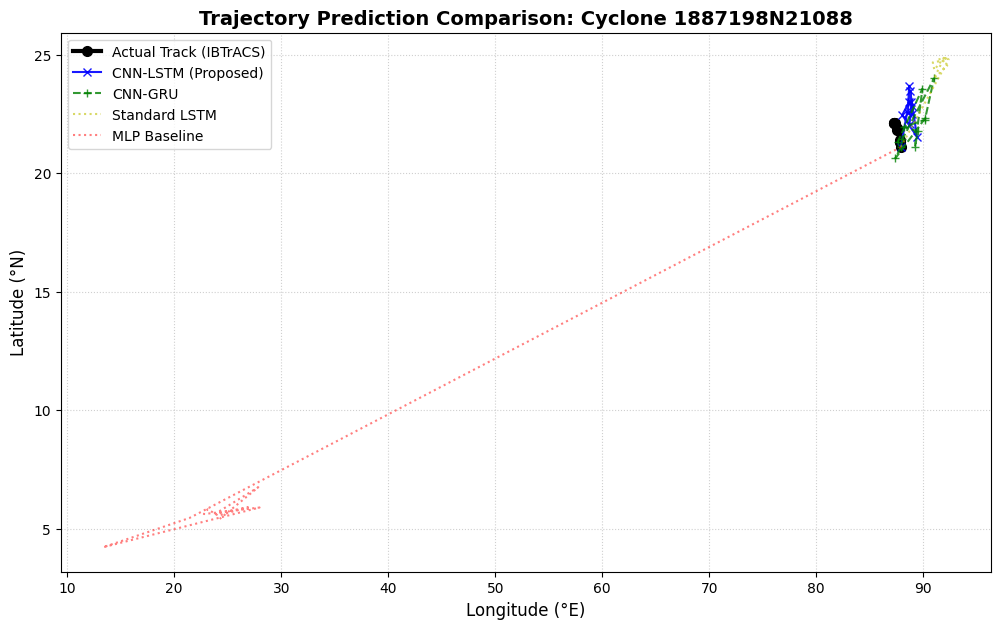

In [124]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))

# Actual Track
plt.plot(cyclone_df['LON'], cyclone_df['LAT'], 'ko-', label='Actual Track (IBTrACS)', linewidth=3, markersize=7)

# Hybrid Models
plt.plot(cyclone_df['CNN_LSTM_longitude'], cyclone_df['CNN_LSTM_latitude'], 'b-x', label='CNN-LSTM (Proposed)', alpha=0.9)
plt.plot(cyclone_df['CNN_GRU_longitude'], cyclone_df['CNN_GRU_latitude'], 'g--+', label='CNN-GRU', alpha=0.8)

# Baselines
plt.plot(cyclone_df['LSTM_longitude'], cyclone_df['LSTM_latitude'], 'y:', label='Standard LSTM', alpha=0.6)
plt.plot(cyclone_df['MLP_longitude'], cyclone_df['MLP_latitude'], 'r:', label='MLP Baseline', alpha=0.5)

plt.title(f'Trajectory Prediction Comparison: Cyclone {target_sid}', fontsize=14, fontweight='bold')
plt.xlabel('Longitude (°E)', fontsize=12)
plt.ylabel('Latitude (°N)', fontsize=12)
plt.legend(frameon=True, loc='best')
plt.grid(True, linestyle=':', alpha=0.6)

plt.savefig('Bangladesh_Cyclone_Case_Study.png', dpi=300, bbox_inches='tight')
plt.show()

In [126]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 12.1 MB/s eta 0:00:00


# **CNN-LSTM Track:**

/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


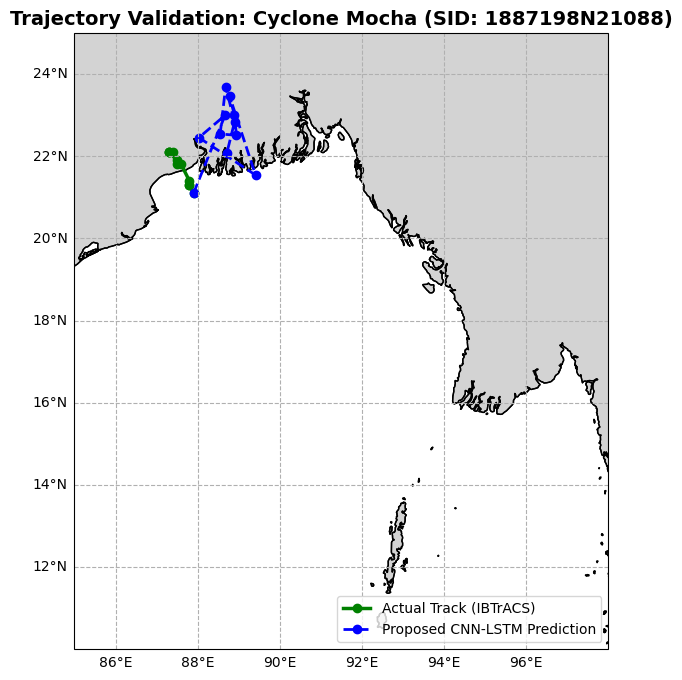

In [127]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature

original_lons = cyclone_df['LON'].values
original_lats = cyclone_df['LAT'].values

predicted_lons = cyclone_df['CNN_LSTM_longitude'].values
predicted_lats = cyclone_df['CNN_LSTM_latitude'].values

map_proj = ccrs.PlateCarree()


fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": map_proj})

# Actual track (IBTrACS)
ax.plot(original_lons, original_lats, 'go-', linewidth=2.5, transform=map_proj, label='Actual Track (IBTrACS)')

# CNN-LSTM track
ax.plot(predicted_lons, predicted_lats, 'bo--', linewidth=2, transform=map_proj, label='Proposed CNN-LSTM Prediction')

# Adding Geography features for Bangladesh/Bay of Bengal
land_feature = NaturalEarthFeature('physical', 'land', '10m', edgecolor='black')
ax.add_feature(land_feature, facecolor='lightgray')

# Adding coastlines and borders for better context
ax.coastlines(resolution='10m')


gl = ax.gridlines(draw_labels=True, linestyle='--')
gl.top_labels = False
gl.right_labels = False


ax.set_extent([85, 98, 10, 25], crs=map_proj)

ax.set_title(f'Trajectory Validation: Cyclone Mocha (SID: {target_sid})', fontsize=14, fontweight='bold')


plt.legend(loc='lower right')
plt.savefig('CNN_LSTM_Bangladesh_Track.png', dpi=300, bbox_inches='tight')

plt.show()

# **CNN-GRU Track:**

/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


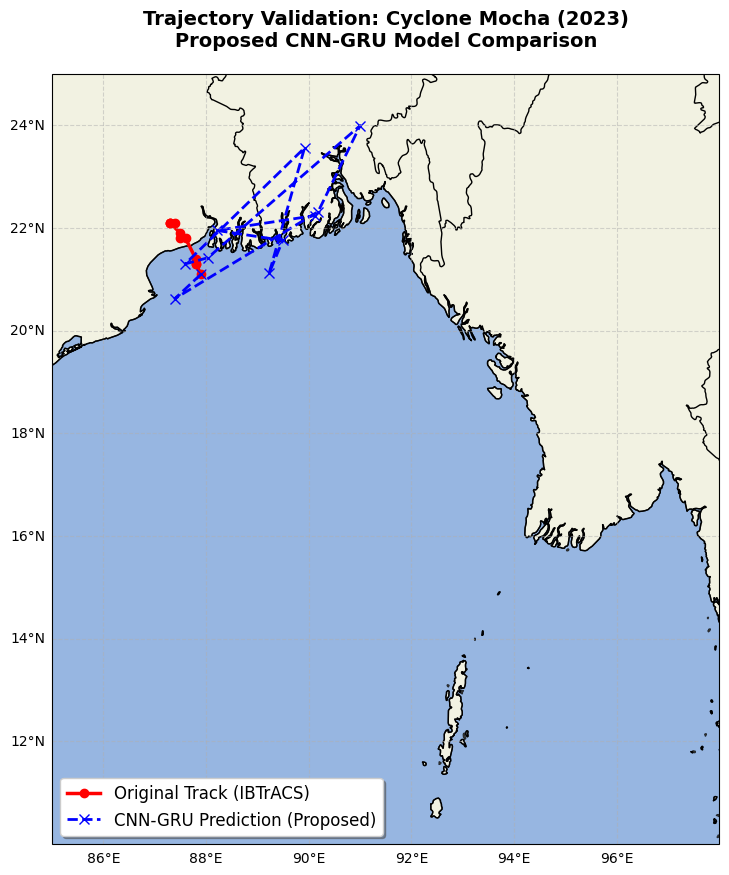

In [128]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature

original_lons = cyclone_df['LON'].values
original_lats = cyclone_df['LAT'].values
predicted_lons = cyclone_df['CNN_GRU_longitude'].values
predicted_lats = cyclone_df['CNN_GRU_latitude'].values


map_proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection=map_proj)

land = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                    edgecolor='black',
                                    facecolor=cfeature.COLORS['land'])
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '10m',
                                     facecolor=cfeature.COLORS['water'])

ax.add_feature(ocean)
ax.add_feature(land, alpha=0.8)
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1)
ax.add_feature(cfeature.COASTLINE, linewidth=1)

# Actual Track
ax.plot(original_lons, original_lats, color='red', marker='o',
        linewidth=2.5, markersize=6, transform=map_proj, label='Original Track (IBTrACS)')

# CNN-GRU BEST MODEL (Blue dashed line with crosses)
ax.plot(predicted_lons, predicted_lats, color='blue', marker='x',
        linewidth=2, markersize=7, linestyle='--', transform=map_proj, label='CNN-GRU Prediction (Proposed)')


ax.set_extent([85, 98, 10, 25], crs=map_proj)


gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10, 'color': 'black'}
gl.ylabel_style = {'size': 10, 'color': 'black'}


plt.title(f'Trajectory Validation: Cyclone Mocha (2023)\nProposed CNN-GRU Model Comparison',
          fontsize=14, fontweight='bold', pad=20)

plt.legend(loc='lower left', frameon=True, shadow=True, fontsize=12)

plt.savefig('CNN_GRU_Professional_Map.png', dpi=300, bbox_inches='tight')
plt.show()

/usr/local/lib/python3.12/dist-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


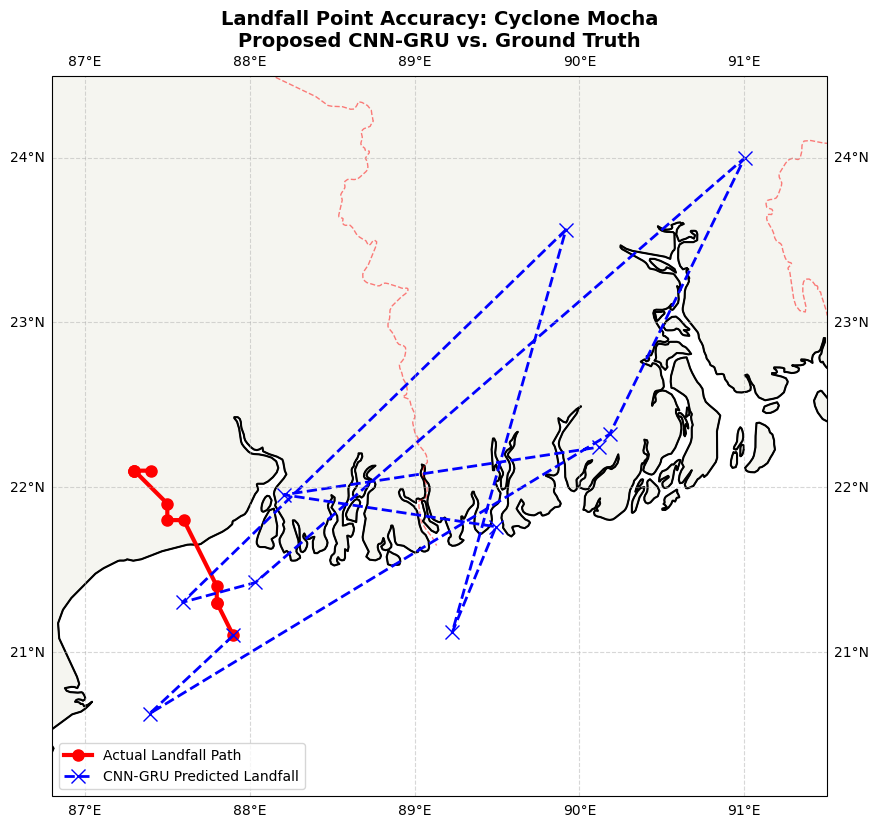

In [129]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


lons_obs = cyclone_df['LON'].values
lats_obs = cyclone_df['LAT'].values
lons_gru = cyclone_df['CNN_GRU_longitude'].values
lats_gru = cyclone_df['CNN_GRU_latitude'].values

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())


ax.add_feature(cfeature.LAND.with_scale('10m'), facecolor='#f5f5f0', edgecolor='black')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=1.5)
ax.add_feature(cfeature.BORDERS.with_scale('10m'), linestyle='--', color='red', alpha=0.5)


ax.plot(lons_obs, lats_obs, 'ro-', label='Actual Landfall Path', markersize=8, linewidth=3)
ax.plot(lons_gru, lats_gru, 'bx--', label='CNN-GRU Predicted Landfall', markersize=10, linewidth=2)


all_lons = list(lons_obs) + list(lons_gru)
all_lats = list(lats_obs) + list(lats_gru)

ax.set_extent([min(all_lons)-0.5, max(all_lons)+0.5,
               min(all_lats)-0.5, max(all_lats)+0.5],
              crs=ccrs.PlateCarree())

ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
plt.title(f'Landfall Point Accuracy: Cyclone Mocha\nProposed CNN-GRU vs. Ground Truth', fontsize=14, fontweight='bold')
plt.legend(loc='lower left')

plt.savefig('Mocha_Landfall_Zoom.png', dpi=300)
plt.show()

# **LSTM Track:**

/tmp/ipython-input-3558295189.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(predicted_lons, predicted_lats, 'bo-', color='blue', linewidth=2, transform=map_proj, label='LSTM Predicted Track')


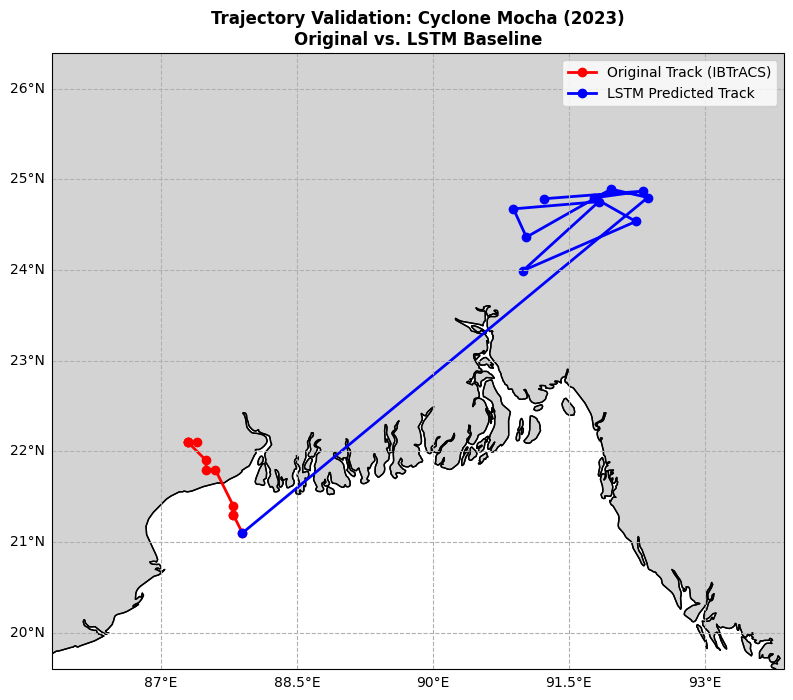

In [130]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature


original_lons = cyclone_df['LON'].values
original_lats = cyclone_df['LAT'].values
predicted_lons = cyclone_df['LSTM_longitude'].values
predicted_lats = cyclone_df['LSTM_latitude'].values

map_proj = ccrs.PlateCarree()


fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": map_proj})

land_feature = NaturalEarthFeature('physical', 'land', '10m', edgecolor='black')
ax.add_feature(land_feature, facecolor='lightgray')
ax.coastlines(resolution='10m')


ax.plot(original_lons, original_lats, 'ro-', linewidth=2, transform=map_proj, label='Original Track (IBTrACS)')
ax.plot(predicted_lons, predicted_lats, 'bo-', color='blue', linewidth=2, transform=map_proj, label='LSTM Predicted Track')

# LSTM
all_lons = list(original_lons) + list(predicted_lons)
all_lats = list(original_lats) + list(predicted_lats)
ax.set_extent([min(all_lons)-1.5, max(all_lons)+1.5, min(all_lats)-1.5, max(all_lats)+1.5], crs=map_proj)


gl = ax.gridlines(draw_labels=True, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.set_title(f'Trajectory Validation: Cyclone Mocha (2023)\nOriginal vs. LSTM Baseline', fontsize=12, fontweight='bold')

plt.legend()
plt.savefig('/content/plotssaved/LSTM_Mocha.png', dpi=300)
plt.show()

# **MLP Track:**

/tmp/ipython-input-2758275319.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "mo-" (-> color='m'). The keyword argument will take precedence.
  ax.plot(predicted_lons_mlp, predicted_lats_mlp, 'mo-', color='magenta', linewidth=2, transform=map_proj, label='MLP Predicted Track')


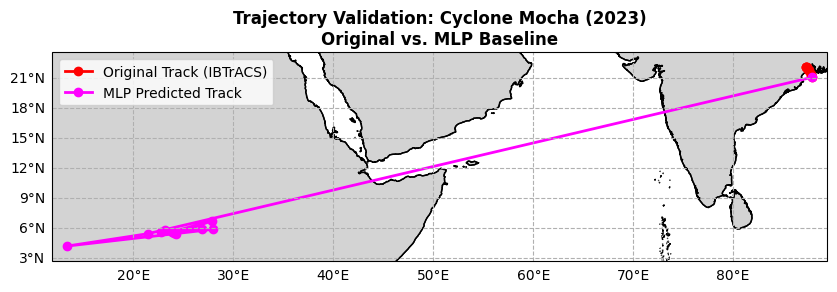

In [131]:
predicted_lons_mlp = cyclone_df['MLP_longitude'].values
predicted_lats_mlp = cyclone_df['MLP_latitude'].values

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": map_proj})
ax.add_feature(land_feature, facecolor='lightgray')
ax.coastlines(resolution='10m')

ax.plot(original_lons, original_lats, 'ro-', linewidth=2, transform=map_proj, label='Original Track (IBTrACS)')
ax.plot(predicted_lons_mlp, predicted_lats_mlp, 'mo-', color='magenta', linewidth=2, transform=map_proj, label='MLP Predicted Track')

all_lons_mlp = list(original_lons) + list(predicted_lons_mlp)
all_lats_mlp = list(original_lats) + list(predicted_lats_mlp)
ax.set_extent([min(all_lons_mlp)-1.5, max(all_lons_mlp)+1.5, min(all_lats_mlp)-1.5, max(all_lats_mlp)+1.5], crs=map_proj)

gl = ax.gridlines(draw_labels=True, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.set_title(f'Trajectory Validation: Cyclone Mocha (2023)\nOriginal vs. MLP Baseline', fontsize=12, fontweight='bold')

plt.legend()
plt.savefig('/content/plotssaved/MLP_Mocha.png', dpi=300)
plt.show()